In [2]:
import sys
import os
from pathlib import Path
sys.path.append(os.getcwd().replace("notebooks","utils"))

import pandas as pd
import numpy as np
from math import ceil
from co2_functions import Predicting
import general_purpose as gp

from sklearn.preprocessing import PowerTransformer,RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,\
                                RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.model_selection import RepeatedKFold,train_test_split,\
                                cross_val_score,validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt



In [3]:
df = gp.dataframes_charger("df_clusters_v1.csv")
df.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,...,co2_pc,latitude,longitude,Year,Country,Energy_type,CODE_x,continent,clusters,energy_type
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,...,0.0,6.424,-66.59,1980-01-01,Venezuela,renewables_n_other,VEN,South America,1,0
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,...,0.0,6.424,-66.59,1980-01-01,Venezuela,petroleum_n_other_liquids,VEN,South America,3,3
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,...,0.0,6.424,-66.59,1980-01-01,Venezuela,natural_gas,VEN,South America,3,2
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,...,0.0,6.424,-66.59,1980-01-01,Venezuela,coal,VEN,South America,1,4
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,...,0.0,6.424,-66.59,1981-01-01,Venezuela,renewables_n_other,VEN,South America,1,0


# Recordatorio Clusters:
1. El cluster 0 son países con una producción de energía pequeña, pero no siendo los que menos tienen, y basada principalemnte en el petróleo, el gas natural y el carbón. Aunque son los terceros productores, su contaminación es la segunda mayor. Por lo que podríamos resumir que son países con poca producción y bastantes emisiones de co2, nada eficientes.
2. El cluster 1 se caracteriza por tener países con poca producción y pocas emisiones de co2, son países que no resultan relevantes ni en producción ni en emisiones de co2, se basan en el petróleo en su mayoría, las renovables y el gas natural.
3. El cluster 2 tiene a los países con mayor producción y mayor emisión de co2 del mundo, muy por encima de los otros cluster. Estos son los países más importantes en producción y contaminación. Su producción está basada en el carbón, el gas natural y el petróleo, siendo las tecnologías que más emiten co2 el carbón con diferencia, luego el petróleo y por último el gas natural.
4. El cluster 3 tiene a países con muy buenas producciones de energía mundiales, con un mix muy diversificado, pues usan todas las fuentes de energía en proporciones similares y sus emisiones de co2 son muy bajas, al nivel del cluster 1 para una producción mucho mayor. Diríamos que estos países son los más eficientes y serían el objetivo a seguir.

In [4]:
own_scale = {"renewables_n_other":0,"nuclear":1,"natural_gas":2,"petroleum_n_other_liquids":3,"coal":4}
df["energy_type"] = df.Energy_type.map(own_scale)
df.head(1)

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,...,co2_pc,latitude,longitude,Year,Country,Energy_type,CODE_x,continent,clusters,energy_type
0,279.389,15182.6,0.15,0.155,0.0,104.341,5.67,-0.005,0.0,0.001,...,0.0,6.424,-66.59,1980-01-01,Venezuela,renewables_n_other,VEN,South America,1,0


In [5]:
a_escalar = df.select_dtypes(exclude="object").drop(["latitude","longitude",
                                                    "clusters","energy_type"],
                                                    axis=1)
scaled_vars = gp.escalado(PowerTransformer(),a_escalar,output="df")

df_procesed2 = scaled_vars.copy()
df_procesed2["clusters"] = df.clusters
df_procesed2["energy_type"] = df.energy_type
df_procesed2.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,clusters,energy_type
0,-0.464369,-0.497205,-0.762928,-0.796767,-1.089275,0.007172,0.092487,-0.093147,-1.094163,-0.279813,-0.125788,-0.609601,1,0
1,-0.464369,-0.497205,1.371884,0.193666,-1.089275,0.007172,0.092487,1.415672,-1.094163,0.154807,-0.125788,-0.609601,3,3
2,-0.464369,-0.497205,-0.057938,-0.020843,-1.089275,0.007172,0.092487,-0.091399,-1.094163,-0.057550,-0.125788,-0.609601,3,2
3,-0.464369,-0.497205,-1.113044,-1.203952,-1.089275,0.007172,0.092487,-0.091399,-1.094163,-0.512453,-0.125788,-0.609601,1,4
4,-0.466362,-0.481889,-0.750570,-0.782897,-1.089275,0.052672,0.205185,-0.093147,-1.094163,-0.279813,-0.125788,-0.609601,1,0


Dividimos el dataset por clusters:

In [6]:
df0 = df_procesed2[df_procesed2.clusters==0]
df1 = df_procesed2[df_procesed2.clusters==1]
df2 = df_procesed2[df_procesed2.clusters==2]
df3 = df_procesed2[df_procesed2.clusters==3]

## Variables mediante correlación:
Miramos cuales son las variables más correlacionadas en cada uno de ellos:

In [7]:
whole_dataset = [df0,df1,df2,df3] 
for i in range(len(whole_dataset)):
    numerics = whole_dataset[i].select_dtypes(include="number")
    correlacion = numerics.corr(method="spearman") # usamos spearman por ser menos sensible a valores extremos
    cor_efi = correlacion.eficiency
    mejores_variables = cor_efi[abs(cor_efi) >=0.49]
    print(f"=======para el cluster {i} las mejores variables son=======")
    print(mejores_variables)

=======para el cluster 0 las mejores variables son=======
Energy_production    -0.491642
Energy_consumption    0.613070
CO2_emission          0.643777
balance              -0.809215
eficiency             1.000000
Name: eficiency, dtype: float64
=======para el cluster 1 las mejores variables son=======
CO2_emission    0.858696
eficiency       1.000000
energy_type     0.493804
Name: eficiency, dtype: float64
=======para el cluster 2 las mejores variables son=======
GDP                   0.551676
Population            0.525950
Energy_consumption    0.672081
CO2_emission          0.715697
balance              -0.802255
eficiency             1.000000
Name: eficiency, dtype: float64
=======para el cluster 3 las mejores variables son=======
Energy_consumption   -0.563478
CO2_emission          0.996379
balance               0.552071
eficiency             1.000000
co2_pc                0.786556
energy_type           0.573856
Name: eficiency, dtype: float64


In [8]:
var_corr_0 = ["Energy_production","Energy_consumption","CO2_emission","balance"]
var_corr_1 = ["CO2_emission","energy_type"]
var_corr_2 = ["GDP","Population","Energy_consumption","CO2_emission","balance"]
var_corr_3 = ["Energy_consumption","CO2_emission","balance","co2_pc","energy_type"]

Basicamente podemos ver que en este punto, aunque con diferencias, pero entre todas se repiten las mismas variables con las que nos quedamos en el modelo individual

## Variables mediante VIF:

Para el cluster 0:

In [9]:
df_number0 = df0.select_dtypes(include="number").drop(columns=["clusters","eficiency"])
df_number0 = df_number0.iloc[:,:len(df_number0.columns)-1]

In [10]:
vif_0 = Predicting.sin_multico_unoauno(df0,df_number0.columns.to_list())
vif_0

,Variable,VIF
0,balance,2.91
1,CO2_emission,2.91
2,Population,2.11
3,per_capita_production,2.03
4,energy_dependecy,1.83
5,Energy_intensity_by_GDP,1.52
6,use_intensity_pc,1.39
7,Energy_production,1.30


In [11]:
var_vif_0 =vif_0.Variable.to_list()

In [12]:
var_vif_0

['balance',
 'CO2_emission',
 'Population',
 'per_capita_production',
 'energy_dependecy',
 'Energy_intensity_by_GDP',
 'use_intensity_pc',
 'Energy_production']

Para el cluster 1:

In [13]:
df_number1 = df1.select_dtypes(include="number").drop(columns=["clusters","eficiency"])
df_number1 = df_number1.iloc[:,:len(df_number1.columns)-1]
vif_1 = Predicting.sin_multico_unoauno(df1,df_number1.columns.to_list())
vif_1

,Variable,VIF
0,Population,4.21
1,GDP,3.66
2,per_capita_production,2.99
3,energy_dependecy,2.15
4,Energy_intensity_by_GDP,1.78
5,use_intensity_pc,1.53
6,Energy_production,1.48
7,CO2_emission,1.26
8,co2_pc,1.25
9,balance,1.03


In [14]:
var_vif_1 =vif_1.Variable.to_list()

Para el cluster 2:

In [15]:
df_number2 = df2.select_dtypes(include="number").drop(columns=["clusters","eficiency"])
df_number2 = df_number2.iloc[:,:len(df_number2.columns)-1]
vif_2 = Predicting.sin_multico_unoauno(df2,df_number2.columns.to_list())
vif_2

,Variable,VIF
0,co2_pc,2.99
1,per_capita_production,2.82
2,energy_dependecy,2.13
3,Energy_production,1.80
4,Energy_consumption,1.80
5,Energy_intensity_by_GDP,1.63
6,use_intensity_pc,1.53
7,balance,1.30


In [16]:
var_vif_2 =vif_2.Variable.to_list()

Para el cluster 3:

In [17]:
df_number3 = df3.select_dtypes(include="number").drop(columns=["clusters","eficiency"])
df_number3 = df_number3.iloc[:,:len(df_number3.columns)-1]
vif_3 = Predicting.sin_multico_unoauno(df3,df_number3.columns.to_list())
vif_3

,Variable,VIF
0,Population,4.19
1,per_capita_production,3.88
2,CO2_emission,2.89
3,energy_dependecy,2.66
4,co2_pc,2.14
5,Energy_intensity_by_GDP,1.83
6,Energy_production,1.68
7,use_intensity_pc,1.39
8,balance,1.31


In [18]:
var_vif_3 =vif_3.Variable.to_list()

# Variables mediante RFECV:

In [19]:
estimadores = [AdaBoostRegressor(),Lasso(),Ridge(),ElasticNet(),LinearRegression(),
                RandomForestRegressor(),GradientBoostingRegressor(),
                SVR(kernel="linear"),DecisionTreeRegressor()]

Para el cluster 0:

In [20]:
y = df[df.clusters==0].eficiency
X = df0[[x for x in df0.columns if x not in ["eficiency","clusters"]]]

rfecv_0 = gp.seleccion_variables(X,y,estimadores)
rfecv_0

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 8
el ranking de las variables vistas ha sido
 [1 3 1 1 1 5 2 1 1 1 4 1]
las variables elegidas han sido:
 ['GDP', 'Energy_production', 'Energy_consumption', 'CO2_emission', 'balance', 'energy_dependecy', 'use_intensity_pc', 'energy_type']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6  8  2  4  3 11 12  1  7 10  9  5]
las variables elegidas han sido:
 ['balance']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6  8  2  4  3 11 12  1  7 10  9  5]
las variables elegidas han sido:
 ['balance']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 3
el ranking de las variables vistas ha sido
 [ 2 10  1  1

,variables,veces
6,balance,9
3,Energy_production,6
0,CO2_emission,4
1,Energy_consumption,4
2,Energy_intensity_by_GDP,2
4,GDP,2
8,energy_dependecy,2
9,energy_type,2
11,use_intensity_pc,2
5,Population,1


In [21]:
# escogemos las variables que más han sido elegidas por los estimadores:
rfecv_vars_0 = rfecv_0.variables.to_list()[:4]
rfecv_vars_0

['balance', 'Energy_production', 'CO2_emission', 'Energy_consumption']

Para el cluster 1:

In [22]:
y = df[df.clusters==1].eficiency
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters"]]]

rfecv_1 = gp.seleccion_variables(X,y,estimadores)
rfecv_1

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 12
el ranking de las variables vistas ha sido
 [1 1 1 1 1 1 1 1 1 1 1 1]
las variables elegidas han sido:
 ['GDP', 'Population', 'Energy_production', 'Energy_consumption', 'CO2_emission', 'per_capita_production', 'Energy_intensity_by_GDP', 'balance', 'energy_dependecy', 'use_intensity_pc', 'co2_pc', 'energy_type']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6 12  3  4  2  9 11  5  7  8  1 10]
las variables elegidas han sido:
 ['co2_pc']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6 12  3  5  2  9 11  4  7  8  1 10]
las variables elegidas han sido:
 ['co2_pc']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables selecc

,variables,veces
0,CO2_emission,5
7,co2_pc,5
1,Energy_consumption,4
10,per_capita_production,4
2,Energy_intensity_by_GDP,3
3,Energy_production,3
4,GDP,3
5,Population,3
6,balance,3
8,energy_dependecy,2


In [23]:
# escogemos las variables que más han sido elegidas por los estimadores:
rfecv_vars_1 = rfecv_1.variables.to_list()[:4]
rfecv_vars_1

['CO2_emission', 'co2_pc', 'Energy_consumption', 'per_capita_production']

Para el cluster 2:

In [24]:
y = df[df.clusters==2].eficiency
X = df2[[x for x in df2.columns if x not in ["eficiency","clusters"]]]

rfecv_2 = gp.seleccion_variables(X,y,estimadores)
rfecv_2

c:\Users\ferna\miniconda3\envs\the_bridge_22\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 3
el ranking de las variables vistas ha sido
 [ 7  8  1  2  1  9  3  1  5 10  6  4]
las variables elegidas han sido:
 ['Energy_production', 'CO2_emission', 'balance']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 5
el ranking de las variables vistas ha sido
 [1 3 1 1 8 7 2 1 6 5 4 1]
las variables elegidas han sido:
 ['GDP', 'Energy_production', 'Energy_consumption', 'balance', 'energy_type']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 5
el ranking de las variables vistas ha sido
 [8 3 1 1 1 4 2 1 7 6 5 1]
las variables elegidas han sido:
 ['Energy_production', 'Energy_consumption', 'CO2_emission', 'balance', 'energy_type']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 9
el ranking de

,variables,veces
5,balance,9
2,Energy_production,8
7,energy_type,8
0,CO2_emission,7
1,Energy_consumption,5
3,GDP,2
4,Population,1
6,co2_pc,1
8,per_capita_production,1


In [25]:
# escogemos las variables que más han sido elegidas por los estimadores:
rfecv_vars_2 = rfecv_2.variables.to_list()[:6]
rfecv_vars_2

['balance',
 'Energy_production',
 'energy_type',
 'CO2_emission',
 'Energy_consumption',
 'GDP']

Para el cluster 3:

In [26]:
y = df[df.clusters==3].eficiency
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]]

rfecv_3 = gp.seleccion_variables(X,y,estimadores)
rfecv_3

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 2
el ranking de las variables vistas ha sido
 [ 3  5  1  4  1  6 10  2  8 11  9  7]
las variables elegidas han sido:
 ['Energy_production', 'CO2_emission']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [12 11 10  9  8  7  6  5  4  3  2  1]
las variables elegidas han sido:
 ['energy_type']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [10  6  2  3  1  7  8 12  5 11  4  9]
las variables elegidas han sido:
 ['CO2_emission']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 2
el ranking de las variables vistas ha sido
 [11  2 10  1  9  8  7  6  5  4  3  1]
las variables elegidas han sido:
 ['Energy_consu

,variables,veces
0,CO2_emission,7
2,Energy_production,4
3,balance,2
5,energy_type,2
1,Energy_consumption,1
4,co2_pc,1


In [27]:
rfecv_vars_3 = rfecv_3.variables.to_list()[:4]
rfecv_vars_3

['CO2_emission', 'Energy_production', 'balance', 'energy_type']

# Variables mediante Statsmodels

Para el cluster 0:

In [143]:
y = df_procesed2[df_procesed2.clusters==0].eficiency.values
X = df0[[x for x in df0.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.807    
Dependent Variable:     y                AIC:                         2215.0201
Date:                   2022-12-10 12:11 BIC:                         2277.7258
No. Observations:       1374             Log-Likelihood:              -1095.5  
Df Model:               12               F-statistic:                 479.7    
Df Residuals:           1362             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.809            Scale:                       0.29099  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1         -0.3468        0.0583       -5.9521      0.0000      -0.4611      -0.2325
x2          0.0556        0.0461        1.2059      0.2281      -0.0348       0.1460
x3         -0.4960        0.0424      -11.7117      0.0000      -0.5791      -0.4129
x4          0.1483        0.0772        1.9218      0.0548      -0.0031       0.2997
x5          1.0962        0.1130        9.6997      0.0000       0.8745       1.3179
x6         -0.1646        0.0277       -5.9457      0.0000      -0.2190      -0.1103
x7         -0.0207        0.0211       -0.9826      0.3260      -0.0622       0.0207
x8         -0.1479        0.0428       -3.4538      0.0006      -0.2319      -0.0639
x9         -0.1879        0.0320       -5.8685      0.0000      -0.2507      -0.1251
x10         0.1029        0.0180        5.7264      0.0000       0.0676       0.1381
x11        -0.0696        0.0312       -2.2328      0.0257      -0.1308      -0.0085
x12        -0.0308        0.0247       -1.2470      0.2126      -0.0792       0.0176
-------------------------------------------------------------------------------
Omnibus:                 848.172           Durbin-Watson:              1.678   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           7095.853
Skew:                    -2.870            Prob(JB):                   0.000   
Kurtosis:                12.540            Condition No.:              28      
===============================================================================

"""

Para este cluster, según ols deberíamos eliminar las variables 2,4,7 y 12 dado que no son significativas y no aportan información relevante:

In [144]:
df0[[x for x in df0.columns if x not in ["eficiency","clusters"]]].columns

Index(['GDP', 'Population', 'Energy_production', 'Energy_consumption',
       'CO2_emission', 'per_capita_production', 'Energy_intensity_by_GDP',
       'balance', 'energy_dependecy', 'use_intensity_pc', 'co2_pc',
       'energy_type'],
      dtype='object')

In [145]:
y = df_procesed2[df_procesed2.clusters==0].eficiency.values
X = df0[[x for x in df0.columns if x not in ["eficiency","clusters",
        "Population","Energy_consumption","Energy_intensity_by_GDP",
        "energy_type"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.805    
Dependent Variable:     y                AIC:                         2227.9558
Date:                   2022-12-10 12:11 BIC:                         2269.7596
No. Observations:       1374             Log-Likelihood:              -1106.0  
Df Model:               8                F-statistic:                 708.1    
Df Residuals:           1366             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.806            Scale:                       0.29459  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1         -0.2024        0.0301       -6.7265      0.0000      -0.2614      -0.1433
x2         -0.3774        0.0321      -11.7459      0.0000      -0.4404      -0.3143
x3          1.0461        0.0378       27.6968      0.0000       0.9720       1.1201
x4         -0.1799        0.0192       -9.3834      0.0000      -0.2175      -0.1423
x5         -0.2315        0.0371       -6.2428      0.0000      -0.3042      -0.1588
x6         -0.1139        0.0238       -4.7879      0.0000      -0.1606      -0.0672
x7          0.0803        0.0171        4.6947      0.0000       0.0468       0.1139
x8         -0.0568        0.0254       -2.2346      0.0256      -0.1066      -0.0069
-------------------------------------------------------------------------------
Omnibus:                 843.036           Durbin-Watson:              1.830   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           6803.466
Skew:                    -2.864            Prob(JB):                   0.000   
Kurtosis:                12.275            Condition No.:              6       
===============================================================================

"""

In [28]:
ols_vars_cl0 = df0[[x for x in df0.columns if x not in ["eficiency","clusters",
        "Population","Energy_consumption","Energy_intensity_by_GDP",
        "energy_type"]]].columns.values

In [29]:
ols_vars_cl0

array(['GDP', 'Energy_production', 'CO2_emission',
       'per_capita_production', 'balance', 'energy_dependecy',
       'use_intensity_pc', 'co2_pc'], dtype=object)

Para el cluster 1:

In [148]:
y = df_procesed2[df_procesed2.clusters==1].eficiency.values
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.833    
Dependent Variable:     y                AIC:                         2711.7560
Date:                   2022-12-10 12:11 BIC:                         2780.0778
No. Observations:       2194             Log-Likelihood:              -1343.9  
Df Model:               12               F-statistic:                 912.2    
Df Residuals:           2182             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.834            Scale:                       0.20042  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0601        0.0221        2.7187      0.0066       0.0167       0.1034
x2          0.0186        0.0215        0.8640      0.3877      -0.0236       0.0608
x3         -0.2507        0.1123       -2.2313      0.0258      -0.4710      -0.0304
x4         -0.2049        0.0933       -2.1970      0.0281      -0.3878      -0.0220
x5          2.2438        0.0471       47.6832      0.0000       2.1515       2.3361
x6         -0.0741        0.0161       -4.6072      0.0000      -0.1056      -0.0426
x7         -0.0121        0.0121       -0.9998      0.3175      -0.0359       0.0116
x8         -0.2531        0.1472       -1.7192      0.0857      -0.5417       0.0356
x9          0.0139        0.0189        0.7333      0.4634      -0.0233       0.0510
x10        -0.0091        0.0192       -0.4758      0.6342      -0.0467       0.0285
x11        -1.4719        0.1096      -13.4244      0.0000      -1.6869      -1.2569
x12         0.0581        0.0067        8.6049      0.0000       0.0448       0.0713
-------------------------------------------------------------------------------
Omnibus:                 317.401           Durbin-Watson:              1.948   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           4525.331
Skew:                    -0.033            Prob(JB):                   0.000   
Kurtosis:                10.035            Condition No.:              56      
===============================================================================

"""

En este cluster sería posible eliminar la variable2,7,8,9 y 10 y el modelo debería mejorar, ya que su p-value es mayor que 0.05 (alfa) dado un nivel de significancia del 95%.

In [149]:
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters",
        "Energy_intensity_by_GDP","Population",'use_intensity_pc',
        "balance","energy_dependecy"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.833    
Dependent Variable:     y                AIC:                         2707.7878
Date:                   2022-12-10 12:11 BIC:                         2747.6421
No. Observations:       2194             Log-Likelihood:              -1346.9  
Df Model:               7                F-statistic:                 1562.    
Df Residuals:           2187             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.833            Scale:                       0.20051  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0658        0.0127        5.1755      0.0000       0.0409       0.0907
x2         -0.3704        0.0767       -4.8264      0.0000      -0.5208      -0.2199
x3         -0.0777        0.0572       -1.3581      0.1746      -0.1900       0.0345
x4          2.2407        0.0460       48.6807      0.0000       2.1505       2.3310
x5         -0.0893        0.0097       -9.1756      0.0000      -0.1084      -0.0702
x6         -1.5182        0.1051      -14.4479      0.0000      -1.7242      -1.3121
x7          0.0591        0.0067        8.7981      0.0000       0.0459       0.0722
-------------------------------------------------------------------------------
Omnibus:                 317.559           Durbin-Watson:              1.949   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           4548.644
Skew:                    -0.007            Prob(JB):                   0.000   
Kurtosis:                10.054            Condition No.:              33      
===============================================================================

"""

In [29]:
d = df1[[x for x in df1.columns if x not in ["eficiency","clusters",
        "Energy_intensity_by_GDP","Population",'use_intensity_pc',
        "balance","energy_dependecy"]]]
d.columns

Index(['GDP', 'Energy_production', 'Energy_consumption', 'CO2_emission',
       'per_capita_production', 'co2_pc', 'energy_type'],
      dtype='object')

El r2 se ha quedado igual pero ha bajado algo el aic y el bic. Parece ser que es posible eliminar también la variable 3 que tiene un p-value superior a alfa:

In [151]:
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters",
        "Energy_intensity_by_GDP","Population",'use_intensity_pc',
        "balance","energy_dependecy","Energy_consumption"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.833    
Dependent Variable:     y                AIC:                         2707.6374
Date:                   2022-12-10 12:11 BIC:                         2741.7983
No. Observations:       2194             Log-Likelihood:              -1347.8  
Df Model:               6                F-statistic:                 1822.    
Df Residuals:           2188             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.833            Scale:                       0.20059  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0642        0.0127        5.0730      0.0000       0.0394       0.0891
x2         -0.4540        0.0457       -9.9241      0.0000      -0.5437      -0.3643
x3          2.2419        0.0460       48.7039      0.0000       2.1516       2.3321
x4         -0.0891        0.0097       -9.1546      0.0000      -0.1082      -0.0700
x5         -1.5203        0.1051      -14.4667      0.0000      -1.7263      -1.3142
x6          0.0583        0.0067        8.7152      0.0000       0.0452       0.0715
-------------------------------------------------------------------------------
Omnibus:                 319.479           Durbin-Watson:              1.946   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           4628.241
Skew:                    -0.018            Prob(JB):                   0.000   
Kurtosis:                10.115            Condition No.:              31      
===============================================================================

"""

In [30]:
ols_vars_cl1 = df1[[x for x in df1.columns if x not in ["eficiency","clusters",
        "Energy_intensity_by_GDP","Population",'use_intensity_pc',
        "balance","energy_dependecy","Energy_consumption"]]].columns.values
ols_vars_cl1

array(['GDP', 'Energy_production', 'CO2_emission',
       'per_capita_production', 'co2_pc', 'energy_type'], dtype=object)

Para el cluster 2:

In [153]:
y = df_procesed2[df_procesed2.clusters==2].eficiency.values
X = df2[[x for x in df2.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.994     
Dependent Variable:     y                AIC:                         -6589.8165
Date:                   2022-12-10 12:11 BIC:                         -6522.3445
No. Observations:       2044             Log-Likelihood:              3306.9    
Df Model:               12               F-statistic:                 3.069e+04 
Df Residuals:           2032             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.995            Scale:                       0.0023165 
-------------------------------------------------------------------------------------
            Coef.       Std.Err.          t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1         -0.1027        0.0042       -24.1851      0.0000      -0.1111      -0.0944
x2         -0.0074        0.0037        -1.9989      0.0458      -0.0148      -0.0001
x3         -0.5195        0.0035      -147.7694      0.0000      -0.5264      -0.5126
x4          0.0266        0.0063         4.1876      0.0000       0.0141       0.0390
x5          1.0780        0.0114        94.7567      0.0000       1.0557       1.1003
x6          0.0169        0.0024         7.0151      0.0000       0.0122       0.0216
x7         -0.0116        0.0017        -6.7164      0.0000      -0.0150      -0.0082
x8         -0.0292        0.0009       -32.5571      0.0000      -0.0309      -0.0274
x9         -0.0507        0.0023       -21.6631      0.0000      -0.0552      -0.0461
x10         0.0065        0.0012         5.5462      0.0000       0.0042       0.0088
x11        -0.0341        0.0020       -16.7195      0.0000      -0.0381      -0.0301
x12         0.0240        0.0022        11.1543      0.0000       0.0198       0.0282
--------------------------------------------------------------------------------
Omnibus:                  353.278           Durbin-Watson:              1.796   
Prob(Omnibus):            0.000             Jarque-Bera (JB):           2376.356
Skew:                     -0.635            Prob(JB):                   0.000   
Kurtosis:                 8.128             Condition No.:              44      
================================================================================

"""

In [31]:
ols_vars_cl2 = df2[[x for x in df2.columns if x not in ["eficiency",
                                        "clusters"]]].columns.values

ols_vars_cl2

array(['GDP', 'Population', 'Energy_production', 'Energy_consumption',
       'CO2_emission', 'per_capita_production', 'Energy_intensity_by_GDP',
       'balance', 'energy_dependecy', 'use_intensity_pc', 'co2_pc',
       'energy_type'], dtype=object)

Este modelo parece demasiado bueno para ser verdad, no hay ninguna variable a eliminar.  
Para el cluster 3:

In [155]:
y = df_procesed2[df_procesed2.clusters==3].eficiency.values
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.998     
Dependent Variable:     y                AIC:                         -2996.1759
Date:                   2022-12-10 12:11 BIC:                         -2938.9264
No. Observations:       872              Log-Likelihood:              1510.1    
Df Model:               12               F-statistic:                 4.133e+04 
Df Residuals:           860              Prob (F-statistic):          0.00      
R-squared (uncentered): 0.998            Scale:                       0.0018594 
-------------------------------------------------------------------------------------
             Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1          -0.0090        0.0067       -1.3452      0.1789      -0.0222       0.0041
x2           0.0120        0.0061        1.9573      0.0506      -0.0000       0.0240
x3          -0.1081        0.0055      -19.5353      0.0000      -0.1190      -0.0972
x4           0.0833        0.0057       14.7026      0.0000       0.0722       0.0944
x5           0.9720        0.0040      241.8348      0.0000       0.9641       0.9799
x6           0.0154        0.0048        3.1881      0.0015       0.0059       0.0249
x7          -0.0148        0.0033       -4.4889      0.0000      -0.0213      -0.0084
x8           0.0074        0.0052        1.4073      0.1597      -0.0029       0.0176
x9           0.0017        0.0033        0.5111      0.6094      -0.0048       0.0081
x10          0.0012        0.0025        0.4871      0.6263      -0.0038       0.0062
x11          0.0352        0.0054        6.4952      0.0000       0.0245       0.0458
x12          0.0018        0.0019        0.9516      0.3416      -0.0020       0.0057
--------------------------------------------------------------------------------
Omnibus:                  173.449           Durbin-Watson:              0.786   
Prob(Omnibus):            0.000             Jarque-Bera (JB):           3534.482
Skew:                     -0.275            Prob(JB):                   0.000   
Kurtosis:                 12.848            Condition No.:              16      
================================================================================

"""

En este modelo sale muy buen r2 pero podrían eliminarse las variables 1,2,8,9,10,12:

In [156]:
df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]].columns

Index(['GDP', 'Population', 'Energy_production', 'Energy_consumption',
       'CO2_emission', 'per_capita_production', 'Energy_intensity_by_GDP',
       'balance', 'energy_dependecy', 'use_intensity_pc', 'co2_pc',
       'energy_type'],
      dtype='object')

In [157]:
y = df_procesed2[df_procesed2.clusters==3].eficiency.values
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters",
    "GDP","Population","balance","energy_type","use_intensity_pc",
    "energy_dependecy"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.998     
Dependent Variable:     y                AIC:                         -2996.2976
Date:                   2022-12-10 12:11 BIC:                         -2967.6728
No. Observations:       872              Log-Likelihood:              1504.1    
Df Model:               6                F-statistic:                 8.212e+04 
Df Residuals:           866              Prob (F-statistic):          0.00      
R-squared (uncentered): 0.998            Scale:                       0.0018718 
-------------------------------------------------------------------------------------
             Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1          -0.1018        0.0035      -29.0791      0.0000      -0.1087      -0.0950
x2           0.0796        0.0028       28.3757      0.0000       0.0741       0.0851
x3           0.9703        0.0037      264.9809      0.0000       0.9631       0.9775
x4           0.0058        0.0019        3.0185      0.0026       0.0020       0.0096
x5          -0.0105        0.0018       -5.7133      0.0000      -0.0141      -0.0069
x6           0.0372        0.0053        7.0739      0.0000       0.0269       0.0475
--------------------------------------------------------------------------------
Omnibus:                  167.775           Durbin-Watson:              0.794   
Prob(Omnibus):            0.000             Jarque-Bera (JB):           3561.561
Skew:                     -0.180            Prob(JB):                   0.000   
Kurtosis:                 12.894            Condition No.:              7       
================================================================================

"""

In [32]:
ols_vars_cl3 = df3[[x for x in df3.columns if x not in ["eficiency","clusters",
    "GDP","Population","balance","energy_type","use_intensity_pc",
    "energy_dependecy"]]].columns.values

ols_vars_cl3

array(['Energy_production', 'Energy_consumption', 'CO2_emission',
       'per_capita_production', 'Energy_intensity_by_GDP', 'co2_pc'],
      dtype=object)

# Estimadores:
## Base line para el cluster 0:

In [41]:
df_tuning = df.select_dtypes(exclude="object").drop(["latitude","longitude"],axis=1)
df_cluster = df_tuning[df_tuning.clusters==0].reset_index(drop=True)

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=["eficiency","clusters"])

In [33]:
random_state = 0
lista_estimadores = [LinearRegression(),
                    AdaBoostRegressor(DecisionTreeRegressor(),\
                    learning_rate=0.1,random_state=random_state),
                    DecisionTreeRegressor(random_state=random_state),
                    RandomForestRegressor(random_state=random_state),
                    BaggingRegressor(Lasso(),random_state=random_state),
                    SVR(kernel="linear"),
                    GradientBoostingRegressor(random_state=random_state),
                    BaggingRegressor(Ridge(),random_state=random_state),
                    BaggingRegressor(ElasticNet(),random_state=random_state)
                    ]

In [161]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

El mejor de ellos es AdaBoost tanto en R2 con una dispersión entre datos aceptable.

In [162]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

De nuevo el que obtiene un menor error absoluto es AdaBoost.

In [163]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

 Aquí Random Forest obtiene un menor valor de error cuadrático medio respecto a todos los demás, pero AdaBoost tiene la segunda mejor métrica, muy cerca de Random Forest, y una dispersión aunque algo mayor, similar también.

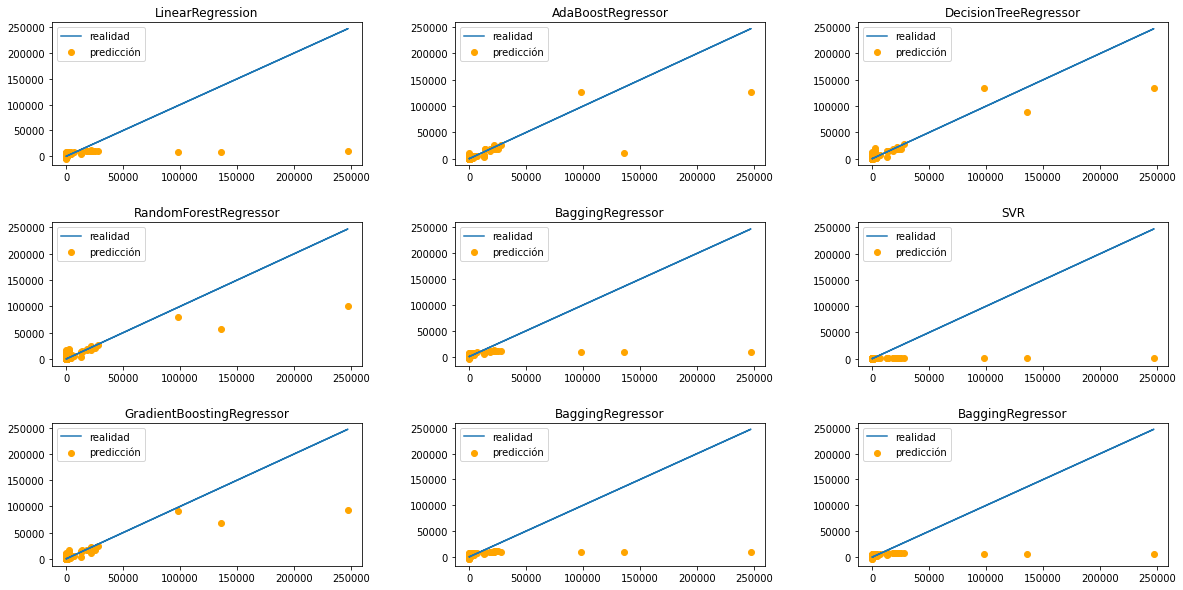

In [164]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,hspace=0.4,figsize=(20,10),columnas=3)

Si los miramos gráficamente podemos ver que los mejor ajustados son el Random Forest,el AdaBoost, el Gradient Boosting y el Decision Tree que son los que mejores métricas de error absoluto y al cuadrado tienen, pero se quedan atrás todos ellos respecto a bondad de ajuste respecto a AdaBoostRegressor, el cual además tiene el menor mae con una desviación típica similar al resto y el mse es muy parecido a RandomForest, que es el que mejor lo hace con una desviación típica entre validaciones similar. Por tanto para el cluster 0 pensamos que el elegido va a ser:
$$\text{AdBoostRegressor(DecisionTreeRegressor())}$$

escogemos los datos para el cluster 0, los dividimos en train y test y luego los transformamos. Lo hacemos ahora de nuevo y en este orden para que los datos contenidos en el test sean realmente nuevos y el modelo no los haya visto.

## SELECCIÓN DE VARIABLES PARA EL CLUSTER 0
### Modelo Cluster 0: variables mediante Correlación

Primero generamos las variables que vamos a usar para el cluster 0:

In [165]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,0,var_corr_0,PowerTransformer())

Ahora volvemos a validar nuestros modelos mediante cross validation, pero usando solo las variables de correlación para ver que modelo es el mejor y elegirlo:

In [166]:
# from importlib import reload
# import co2_functions as co2
# reload(co2)

Hey!, el módulo co2 ha sido importado correctamente 🥳


<module 'co2_functions' from 'c:\\Users\\ferna\\OneDrive\\Documentos\\Data_Science\\MIS_COSAS_DE_THE_BRIDGE\\Proyectos_Machine_Learning\\co2_ml\\src\\utils\\co2_functions.py'>

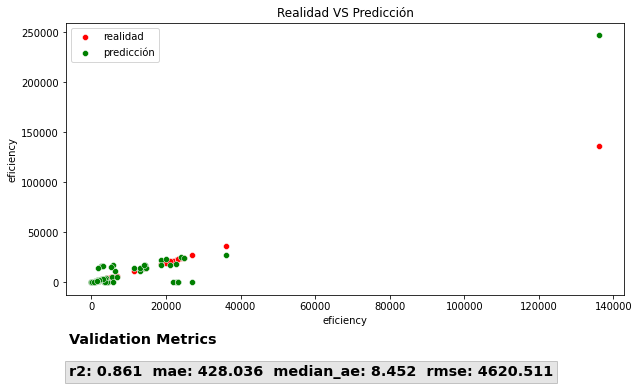

(                                                r2          mae   median_mae
 AdaBoostRegressor(base_estimator=Decisio  0.862314   260.164862     8.952554
 RandomForestRegressor(random_state=0)     0.841197   385.369032     9.149977
 GradientBoostingRegressor(random_state=0  0.792027   487.872943    54.978131
 DecisionTreeRegressor(random_state=0)     0.628443   422.051640    10.073000
 BaggingRegressor(base_estimator=ElasticN  0.169604  2855.420359  1745.600649
 BaggingRegressor(base_estimator=Ridge(),  0.136597  3159.289706  1731.329760
 LinearRegression()                        0.135279  3281.766255  1775.437807
 BaggingRegressor(base_estimator=Lasso(),  0.102231  3295.123216  1641.558728
 SVR(kernel='linear')                     -0.006049  1932.800975   149.425178,
 None)

In [167]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

Vemos que es AdaBoostRegressor el mejor, obteniendo el mayor valor de r2 y el menor valor de la mediana del error absoluto medio. Podemos observar que la mediana es mucho menor que la media del error absoluto, lo que nos indica que los valores extremos positivos están tirando de la media hacia la derecha y por tanto la están influenciando. En este sentido, le damos mayor importancia al r2 y a la mediana del error absoluto como métricas decisorias, ya que por las características de nuestro estudio decidimos que no era conveniente eliminar los valores extremos de nuestro dataset, y por tanto queremos minimizar el efecto de estos a la hora de tomar una decisión.  
Pasamos ahora a ver la validation curve para ver el margen de mejora que podemos conseguir mediante el hyperparameter tunnig:

We see AdaBoostRegressor is the best, gathering the best r2 and median mae metric. We can also see that the median is much lower than the mean absolute error what is telling us the extreme values are pulling right the mean absolute error, so they are influencing the mean metric. In this sense, we are giving more importance to the r2 and median metrics than the mean metric as decisory ones because we decided we should keep the extreme values in the dataset because of the kind of data we are dealing off. In consecuence, we want to minimize the effect of these data on the metrics.
Let's now take a look at the validation curve for the model chosen so we can see if there is room for improvement and other considerations:

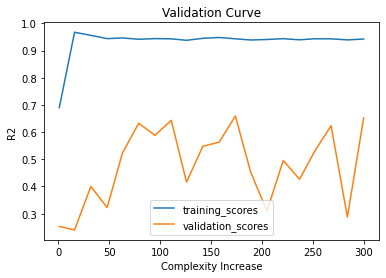

In [168]:
Predicting.val_curve_plot(dfc,AdaBoostRegressor(),var_corr_0,
                            "n_estimators",np.linspace(1,300,20,dtype=int))

Observamos que el modelo aprende bien con el training pero no lo hace tan bien a la hora de generalizar en la curva validation, alcanzando un valor máximo de r2 aproximadamente de 0.68. Esto nos genera un error de generalización bastante grande y nos indica que el modelo sufre de varianza u overfitting. Dado este diagnóstico, podemos ver que con el aumento de la complejidad no es posible mejorar el modelo y por tanto hemos barajado las siguientes opciones:
1. Los datos del validation no son lo suficientemente representativos del conjunto de datos de training. En esto puede que esté influyendo los valores extremos que hemos mantenido.
2. Estamos tratando de predecir un asunto sencillo con un modelo demasiado complejo  

Si ponemos en contraposición este modelo, con uno mucho más sencillo como es Linear Regression vemos que las métricas que es capaz de conseguir son muy pobres, por lo que es probable que sea más un problema de representatividad de los datos elegidos para el validation. En este sentido, aumentamos el porcentaje de datos para el validation de 0.2 a 0.3 y mantenemos el método de cross validation usando el RepetedKfold. Esto nos ha mejorado algo los números pero se mantiene la gráfica que obteníamos.
Dadas estas conclusiones consideramos que con las asunciones tomadas no es posible mejorar mucho más el modelo en este punto, por lo que vamos a quedarnos con él y a tratar de mejorarlo mediante el ajuste de los hiperparámetros del mismo:

We observe that the model learns well with training but does not do so well when generalizing in the validation curve, reaching a maximum r2 value of approximately 0.68. This generates a fairly large generalization error and indicates that the model suffers from variance or overfitting. Given this diagnosis, we can see that with the increase in complexity it is not possible to improve the model and therefore we have considered the following options:
1. The validation data is not sufficiently representative of the training dataset. This may be influenced by the extreme values we have maintained.
2. We are trying to predict a simple matter with a too complex a model.

If we contrast this model, with a much simpler one such as Linear Regression we see that the metrics it achieves are very poor, so it is likely to be more a problem of representativeness of the data chosen for validation. In this sense, we increase the percentage of data for validation from 0.2 to 0.3 and maintain the method of cross validation using the RepetedKfold. This has improved the numbers somewhat but the graph we obtained is maintained.
Given these conclusions we consider that with the assumptions taken it is not possible to improve the model much more at this point, so we are going to stay with it and try to improve it by adjusting the hyperparameters of it:

In [175]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['linear','square','exponential']
        }

best_estim = Predicting.hiper_tune(AdaBoostRegressor(),params,x_train,
                                        y_train,"r2")
best_estim_corr0 = best_estim

best params: {'n_estimators': 32, 'loss': 'exponential'}
best score: 0.9322356984025632


Vemos que hemos conseguido mejorar el r2 bastante respecto al original mediante los ajustes de los hiperparámetros sin ajustar la mayoría de ellos pues consideramos que no es benerficioso aumentar la complejidad del modelo demasiado. Pasamos a representar el modelo elegido y personalizado para ver como lo hace, volviendo a entrenarlo y validarlo:

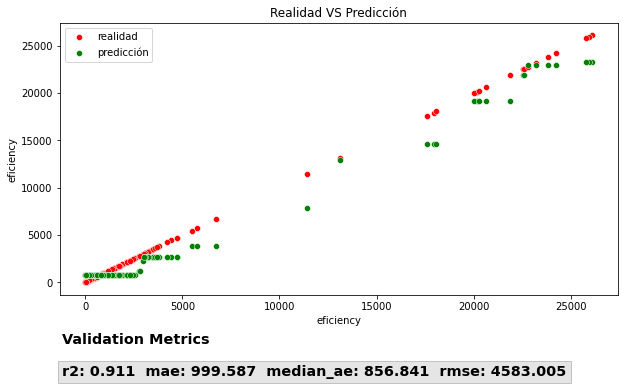

In [176]:
Predicting.cross_val_regression(best_estim_corr0,x_train,y_train,x_test,y_test)

Encontramos que hemos mejorado la generalización del modelo a costa de obtener unos errores más elevados como podemos observar en las métricas. Es decir, ahora nuestro modelo tiene la capacidad de explicar en una mayor proporcion la variabilidad de la target a costa de incurrir en mayores errores a lo largo de sus predicciones. Esto nos parece un buen compromiso dado que en esta situación nustro modelo es más fiable a la hora de predecir con datos que no ha visto pues nos indica que ha captado mejor la tendencia general.
Por último representamos la learning curve de este modelo:

We found that we have improved the generalization of the model at the expense of obtaining higher errors as we can see in the metrics. That is, now our model has the ability to explain in a greater proportion the variability of the target at the cost of incurring greater errors throughout its predictions. 
This seems to us a good compromise given that in this situation our model is more reliable when predicting with data that it has not seen because it indicates that it has better captured the general trend.
Finally we represent the learning curve of this model:

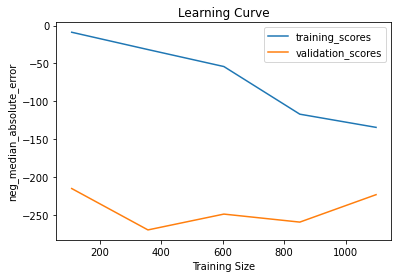

In [181]:
Predicting.learn_curve_plot(dfc,var_corr_0,best_estim_corr0,"neg_median_absolute_error")

observando la curva de aprendizaje realizada con la métrica error absoluto mediano observamos que al principio el modelo tiene un gran bias pero a medida que se va aumentando el número de datos las curvas de training y de validation se van acercando convergiendo hacia un error mediano absoluto menor para el training y mayor para el validation con el objetivo de alcanzar un punto óptimo. Sin embargo, una vez alcanzado el número máximo de datos que contiene el conjunto de datos, existe todavía un gap de generalización elevado (distancia entre la validation curve y la training curve) por lo que no llegan nunca a converger indicándonos que con un mayor número de datos aún sería posible mejorar este modelo.


Observing the learning curve made with the Median Absolute Error metric, we observe that at the beginning the model has a large BIAS but as the number of data increases, the training and validation curves are approaching, converging towards a lower absolute median error for training and greater for validation in order to reach an optimal point. However, once the maximum number of data contained in the dataset has been reached, there is still a high generalization gap (distance between the validation curve and the training curve) so they never converge, indicating that with a greater number of data it would still be possible to improve this model.

### Modelo Cluster 0: variables mediante Vif

In [35]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,0,var_vif_0,PowerTransformer())

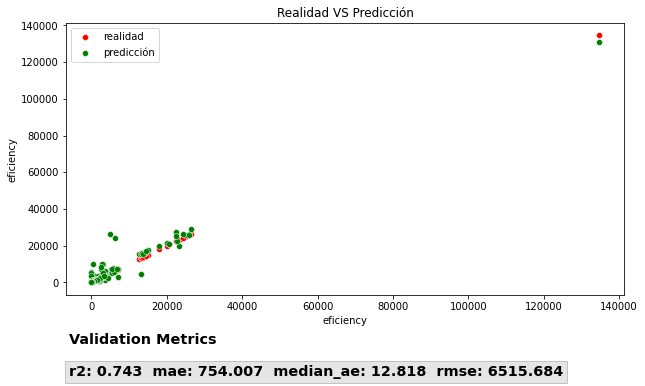

(                                                r2          mae   median_mae
 RandomForestRegressor(random_state=0)     0.762697   625.287619    12.498328
 GradientBoostingRegressor(random_state=0  0.640076   798.332578    63.580225
 AdaBoostRegressor(base_estimator=Decisio  0.613233   494.410476    10.033750
 BaggingRegressor(base_estimator=ElasticN  0.161945  3159.047473  2047.312714
 BaggingRegressor(base_estimator=Lasso(),  0.139656  3597.842680  2217.666644
 LinearRegression()                        0.127415  3639.890280  2231.934108
 BaggingRegressor(base_estimator=Ridge(),  0.114807  3564.771442  2290.685308
 DecisionTreeRegressor(random_state=0)     0.037863   831.080239    14.616500
 SVR(kernel='linear')                     -0.017252  2149.281933   144.083809,
 None)

In [159]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

En este modelo mediante la selección de variables usando el vif podemos ver que el estimador que mejor explica la variabilidad de la target es Random Forest Regressor con un 0.74-0.76 aproximadamente y un error mediano de 12.49, que a diferencia del error medio es mucho menor. Esto nos indica, que al igual que en el caso anterior existen pocos errores en los datos con valores extremos pero afectan bastante a la media por su magnitud.

In this model by selecting variables using the vif we can see that the estimator that best explains the variability of the target is Random Forest Regressor with an approximately 0.74-0.76 and a median error of 12.49, which difference from the average error is much lower. This indicates that, as in the previous case, there are few errors in the data with extreme values but they affect the average enough due to its magnitude.

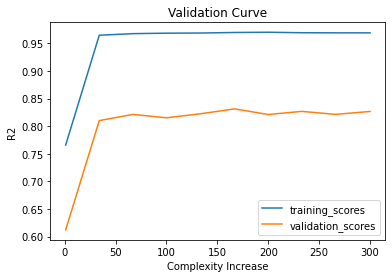

In [160]:
Predicting.val_curve_plot(dfc,RandomForestRegressor(),var_vif_0,
                        "n_estimators",np.linspace(1,300,10,dtype=int))

Podemos ver que existe algo de overfitting en el modelo, puesto que aunque vemos que el modelo aprende bien en la curva de training, el nivel de r2 que alcanza la curva de validation está un poco lejos de la de training, estando entre 0.80 y 0.85. Aún así, consideramos que es un gap de generalización aceptable para la distribución de datos que tenemos y según hemos visto en el resto de combinaciones.

We can see that there is some overfitting in the model, since although we see that the model learns well in the training curve, the level of r2 that reaches the validation curve is a little far from that of training, being between 0.80 and 0.85. Even so, we consider that it is an acceptable generalization gap for the distribution of data that we have and as we have seen in the rest of the combinations.

In [36]:
params = {
        "n_estimators":np.linspace(1,200,10,dtype=int),
        "criterion":['squared_error','absolute_error','friedman_mse','poisson'],
        "max_depth":np.linspace(1,100,dtype=int)
        }

best_estim = Predicting.hiper_tune(RandomForestRegressor(),params,x_train,
                                        y_train,"r2")
best_estim_vif0 = best_estim

best params: {'n_estimators': 111, 'max_depth': 71, 'criterion': 'absolute_error'}
best score: 0.9003105718779771


Vemos que hemos podido conseguir una pequeña mejora

We see that we have been able to achieve a small improvement

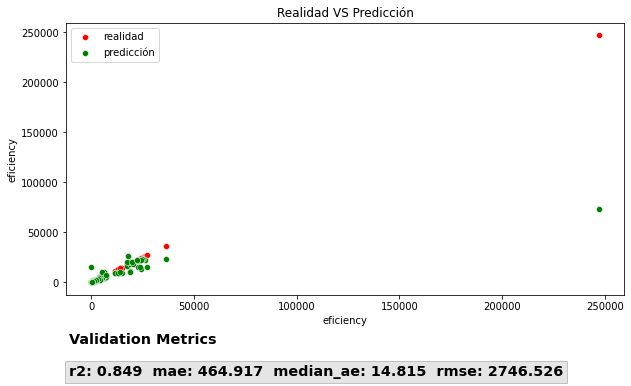

In [37]:
Predicting.cross_val_regression(best_estim_vif0,x_train,y_train,x_test,y_test)

Vemos que hemos podido mejorar la capacidad de explicación de la variabilidad de la target reduciendo el error absoluto medio y aumentando algo el error absoluto mediano. Además es un modelo que tiene una rmse bastante menor por lo que los grandes errores de los valores extremos le están afectando menos y es un modelo que en general tiene una mejor capacidad de generalizar que el de su base line.


We see that we have been able to improve the ability to explain the variability of the target by reducing the average absolute error and increasing the median absolute error somewhat. It is also a model that has a much lower rmse so the large errors of extreme values are affecting it less and it is a model that in general has a better ability to generalize than that of its base line.

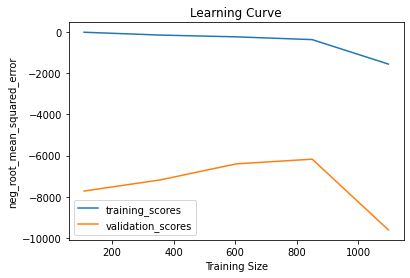

In [38]:
Predicting.learn_curve_plot(dfc,var_vif_0,best_estim_vif0,"neg_root_mean_squared_error")

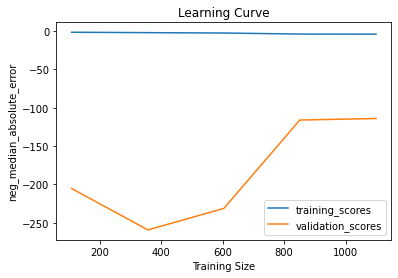

In [39]:
Predicting.learn_curve_plot(dfc,var_vif_0,best_estim_vif0,"neg_median_absolute_error")

Mirando la learning curve en la que usamos como métrica la raíz cuadrada del error cuadrático medio podemos ver que a medida que se va aumentando el número de datos se van aproximando las curvas, pero no llegan a converger nunca por lo que podríamos establecer que con un mayor número de datos sería posible mejorar el modelo. Sin embargo, dadas las características de nuestros datos, consideramos que es más fiable usar la mediana del error absoluto y por tanto realizamos su learning curve con el objetivo de confirmar las conclusiones anteriores. En este sentido, observamos que las líneas convergen de una manera más pronunciada pero no lo suficiente y por tanto se confirman nuestras suposiciones anteriores.


Looking at the learning curve in which we use as a metric the square root of the mean square error we can see that as the number of data increases, the curves are approaching, but they never converge so we could establish that with a greater number of data it would be possible to improve the model. However, given the characteristics of our data, we consider that it is more reliable to use the median of absolute error and therefore we perform its learning curve in order to confirm the previous conclusions. In this sense, we observe that the lines converge in a more pronounced but not sufficient way and therefore our previous assumptions are confirmed.

### Modelo Cluster 0: variables mediante RFECV

In [59]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,0,rfecv_vars_0,PowerTransformer())

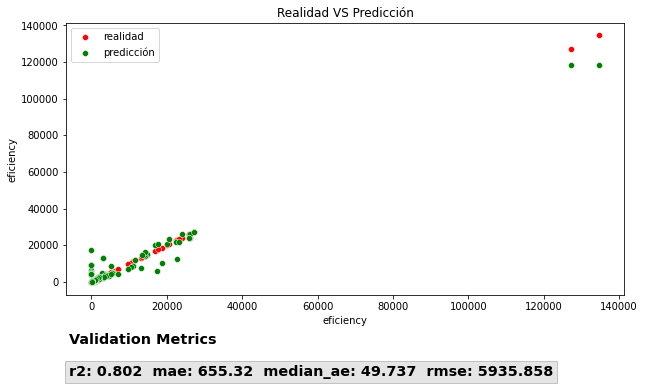

(                                                r2          mae   median_mae
 GradientBoostingRegressor(random_state=0  0.801473   544.159880    48.649428
 RandomForestRegressor(random_state=0)     0.774318   523.860846    10.754213
 AdaBoostRegressor(base_estimator=Decisio  0.697096   351.632153     9.402500
 DecisionTreeRegressor(random_state=0)     0.244888   729.626461    11.875000
 BaggingRegressor(base_estimator=ElasticN  0.174001  2840.531376  1684.506913
 LinearRegression()                        0.150413  3295.123432  1821.095372
 BaggingRegressor(base_estimator=Ridge(),  0.138607  3266.120649  1757.154813
 BaggingRegressor(base_estimator=Lasso(),  0.130658  3308.753427  1827.409105
 SVR(kernel='linear')                     -0.008283  1957.274903   164.836474,
 None)

In [63]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

Vemos que en este caso el mejor estimador es GradientBoosting Regressor con un r2 de 0.8014, un mae de 544.16 y un error absoluto mediano de 48.65.

We see that in this case the best estimator is GradientBoosting Regressor with an r2 of 0.8014, a mae of 544.16 and a median absolute error of 48.65.

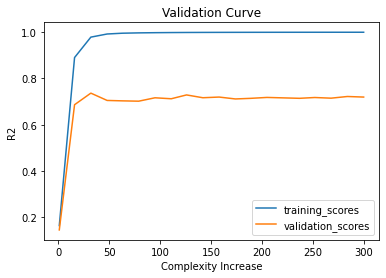

In [64]:
Predicting.val_curve_plot(dfc,GradientBoostingRegressor(),rfecv_vars_0,
                            "n_estimators",np.linspace(1,300,20,dtype=int))

En la validation curve vemos como existe una discrepancia entre el valor de la training curve y de la validation curve, teniendo un gap de generalización grande entre ellas y por tanto el modelo es capaz de generalizar, pero no de una manera extraordinaria. 
Dado el estudio anterior realizado, el cual obtenía muchos mejores resultados deducimos que la configuración del modelo con las variables elegidas mediante este método hace que no sea la más adecuada, pues no capta de manera correcta la tendencia general del conjunto de datos. Aún así, vamos a tratar de mejorarlo algo con el ajuste de sus hiperparámetros:

In the validation curve we see how there is a discrepancy between the value of the training curve and the validation curve, having a large generalization gap between them, and therefore that, the model is able to predict, but not very well with new data. 
Given the previous study, which obtained much better results, we deduced that the configuration of the model with the variables chosen by this method makes it not the most appropriate, since it does not correctly capture the general trend of the data set. Still, let's try to improve it somewhat with the adjustment of its hyperparameters:

In [66]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['squared_error','absolute_error','huber','quantile'],
        "criterion":['friedman_mse','squared_error'],
        "alpha":np.linspace(0.1,0.9,10,dtype=float)
        }

best_estim = Predicting.hiper_tune(GradientBoostingRegressor(),params,x_train,
                                        y_train,"r2")
best_estim_rfecv0 = best_estim

best params: {'n_estimators': 284, 'loss': 'huber', 'criterion': 'friedman_mse', 'alpha': 0.9}
best score: 0.8413970477990317


Dada la validation curve y las conclusiones hayadas pensabamos que la mejora a conseguir no sería muy elevada, como así ha sido, sin embargo hemos mejorado más de lo que esperabamos.

Given the validation curve and the conclusions, we thought that the improvement to be achieved, would not be very high as it has been, however we have improved more than we expected.

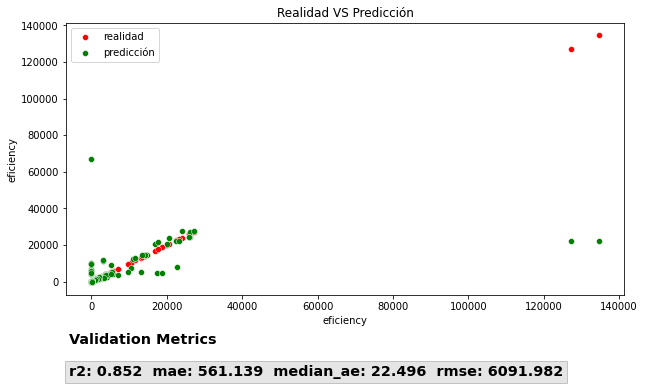

In [67]:
Predicting.cross_val_regression(best_estim_rfecv0,x_train,y_train,x_test,y_test)

Podemos observar que con nuestro modelo ajustado mediante hiperparámetros obtenemos un mayor valor de r2, con lo cual explicamos mejor la variabilidad de nuestra target a través de sus variables independientes y el error mediano se ha reducido en más de la mitad, por lo que es un mejor modelo que el inicial. Pasemos a ver la lerning curve:

We can see that with our model adjusted by hyperparameters we obtain a higher value of r2, with which we better explain the variability of our target through its independent variables and the median error has been reduced by more than half, so it is a better model than the initial one. Let's look at the lerning curve:

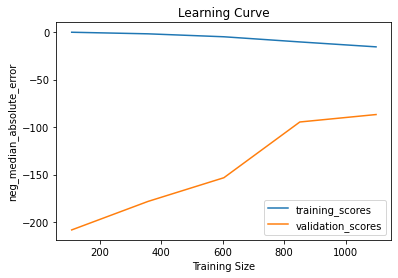

In [69]:
Predicting.learn_curve_plot(dfc,rfecv_vars_0,best_estim_rfecv0,"neg_median_absolute_error")

En la learning curve vemos como a medida que añadimos nuevos datos el modelo lo va haciendo cada vez mejor a la hora de generalizar reduciendo el bias y aumentando la varianza. Sin embargo, con los datos que tenemos no llegamos a conseguir un modelo que converja del todo y por tanto, añadiendo nuevos datos podríamos seguir mejorandolo hasta tener un menor grado de error de generalización. Aún así, consideramos que el error mediano no es extremadamente alto, aunque hemos encontrado otros modelos que lo hacen mejor.

In the learning curve we see how as we add new data the model is doing better and better when it comes to generalizing, reducing the bias and increasing the variance. However, with the data that we have, we do not get a model that converges completely, and therefore, adding new data would improve it. Still, we consider the median error not to be extremely high, although we've found other models that do better.

### Modelo Cluster 0: variables mediante OLS de Statsmodels

In [70]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,0,ols_vars_cl0,PowerTransformer())

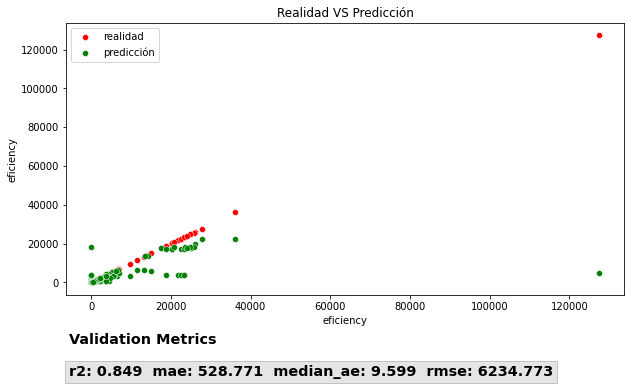

(                                                r2          mae   median_mae
 AdaBoostRegressor(base_estimator=Decisio  0.831198   382.811902     9.594500
 RandomForestRegressor(random_state=0)     0.772439   487.265580    13.127011
 GradientBoostingRegressor(random_state=0  0.630696   792.357758    54.708853
 DecisionTreeRegressor(random_state=0)     0.243060   803.739542    13.614500
 BaggingRegressor(base_estimator=ElasticN  0.152603  2939.009963  1918.189294
 BaggingRegressor(base_estimator=Ridge(),  0.129525  3495.934474  2161.062511
 LinearRegression()                        0.126388  3274.764201  2124.171212
 BaggingRegressor(base_estimator=Lasso(),  0.097032  3445.058188  2129.973125
 SVR(kernel='linear')                     -0.009724  1910.514517   127.342586,
 None)

In [71]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

In this model configuration we can observe that AdaBoost Regressor has achieve the best R2 and Median absolute error value. As we can see in the graph the extreme values influences the mean absolute error. Anyways, we choose the best model and take a look at the validation curve so we can explore the improvement options using it:

En esta configuración del modelo podemos observar que AdaBoost Regressor ha logrado el mejor valor de error absoluto mediano y R2. Como podemos ver en el gráfico los valores extremos influyen en el error absoluto medio. De todos modos, elegimos el mejor modelo y echamos un vistazo a la curva de validación para poder explorar las opciones de mejora:

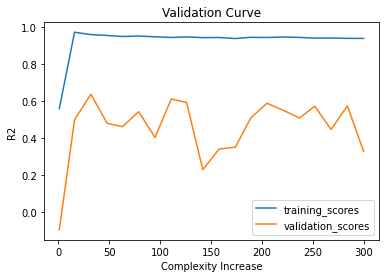

In [72]:
Predicting.val_curve_plot(dfc,AdaBoostRegressor(),ols_vars_cl0,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

As in the other configurations where the selected model has been AdaBoost Regressor we see that the validation curve is irregular along its pace as the complexity increases and that the validation curve is not able to reach an r2 value close to the training one. This indicates that the model learns well but it struggles at predicting new data not seen before so the model suffers from overfitting. As this method is the last and seen the before conclusions we think this results are due to the extreme values kept. Let's try to improve the model with hyperparameter tuning:

Al igual que en las otras configuraciones donde el modelo seleccionado ha sido AdaBoost Regressor, vemos que la curva de validación es irregular a lo largo de su recorrido a medida que aumenta la complejidad, y que la curva de validación no es capaz de alcanzar un valor de r2 cercano al de entrenamiento. Esto indica que el modelo aprende bien, pero tiene dificultades para predecir nuevos datos no vistos antes, por lo que el modelo sufre de sobreajuste. Como este método es el último y vistas las conclusiones anteriores, creemos que estos resultados se deben a los valores extremos que hemos mantenido. Intentemos mejorar el modelo con el ajuste de hiperparámetros:

In [80]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['linear','square','exponential']
        }

best_estim = Predicting.hiper_tune(AdaBoostRegressor(),params,
                                        x_train,y_train,"r2")

best_estim_ols0 = best_estim

best params: {'n_estimators': 48, 'loss': 'square'}
best score: 0.851806107114837


Tras varios intentos conseguimos mejorar el modelo algo, pero todos ellos han estado rondado el 0.80 de r2 por lo que dada la validation curve que obtuvimos consideramos buena la mejora y que este modelo no tiene mucho más margen de mejora.

After several attempts we managed to improve the model somewhat, but all of them have been around an r2 of 0.80 so, given the validation curve we obtained, we consider the improvement good and that this model does not have much more room for improvement.

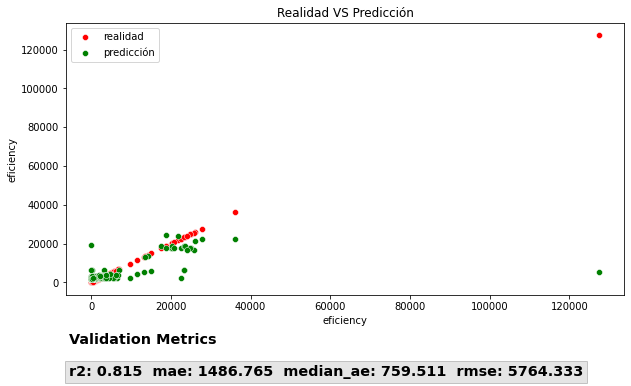

In [81]:
Predicting.cross_val_regression(best_estim_ols0,x_train,y_train,x_test,y_test)

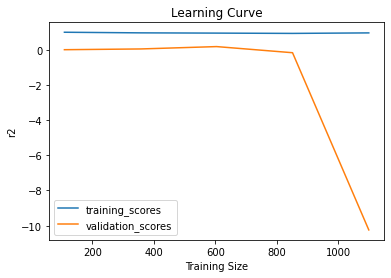

In [82]:
Predicting.learn_curve_plot(dfc,ols_vars_cl0,best_estim_ols0,"r2")

If we see the learning curve made using r2 score we see the model converges but at a score very low. Seen this, we plot the same curve but using the median absolute error and we encounter that the model converges until 400 data points aproximately and then the validation curve drops drastically so we can think that this model

Si vemos la curva de aprendizaje realizada usando r2 score vemos que el modelo converge pero en unos valores  muy bajos. Visto esto, graficamos la misma curva pero usando el error absoluto mediano y nos encontramos con que el modelo converge hasta 400 puntos de datos aproximadamente y luego la curva de validación cae drásticamente, por lo que podemos pensar que en este modelo, a partir de cierto punto, existen problemas de representatividad de la distribución de los datos en el validation respecto al training

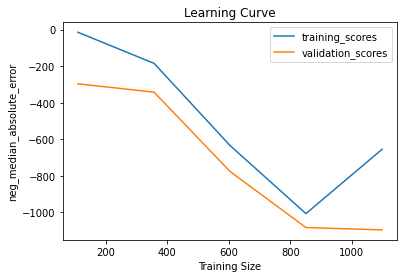

In [87]:
Predicting.learn_curve_plot(dfc,ols_vars_cl0,best_estim_ols0,"neg_median_absolute_error")

### CONCLUSIÓN PARA EL CLUSTER 0:
Se usará el estimador: 
$$\text{Random Forest Regressor}$$ 
Las variables a usar serán las obtenidas mediante VIF:  
`['balance',
 'CO2_emission',
 'Population',
 'per_capita_production',
 'energy_dependecy',
 'Energy_intensity_by_GDP',
 'use_intensity_pc',
 'Energy_production']`

In [42]:
# Reentrenamos el modelo usando todos los datos del subconjunto y lo guardamos para ponerlo en producción:
cl0_x = df_cluster[var_vif_0]
cl0_y = df_cluster.eficiency

pip_0 = Pipeline(steps=[("escalado",PowerTransformer()),
                        ("modelo",best_estim_vif0)]).fit(cl0_x,cl0_y)

gp.models_saver(pip_0["modelo"],"reg_cluster0")

Modelo guardado correctamente


Podemos ver que el modelo realizado con las variables obtenidas mediante el método de la correlación es mejor en las métricas r2 y en complejidad, pero obtiene un error mediano muy elevado respecto el segundo mejor en r2 y el primero en error mediano, que es el modelo realizado con las variables seleccionadas mediante vif. En este sentido, consideramos que aunque la complejidad del modelo se aumenta en el doble eligiendo el vif, con él estamos explicando prácticamente el mismo porcentaje de la variabilidad de la variable dependediente, reduciendo el error mediano absoluto en un porecentaje mucho mayor, y por tanto resulta ser el modelo elegido. De esta manera, reentrenamos el modelo usando todos los datos y lo guardamos para la fase de puesta en producción.

We can see that the model made with the variables obtained by the correlation method is better in the r2 metrics and in complexity, but obtains a very high median error with respect to the second best in r2 and the first in median error, which is the model made with the variables selected by vif.In this sense, we consider that although the complexity of the model is increased by twice choosing the vif, with it we are explaining practically the same percentage of the variability of the dependent variable, reducing the absolute median error by a much higher percentage, and therefore turns out to be the chosen model. In this way, we retrain the model using all the data and save it for the production phase.

## Base line para el cluster 1:

In [204]:
df_cluster = df_tuning[df_tuning.clusters==1].reset_index(drop=True)

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=["eficiency","clusters"])

In [205]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

In [206]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

In [207]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

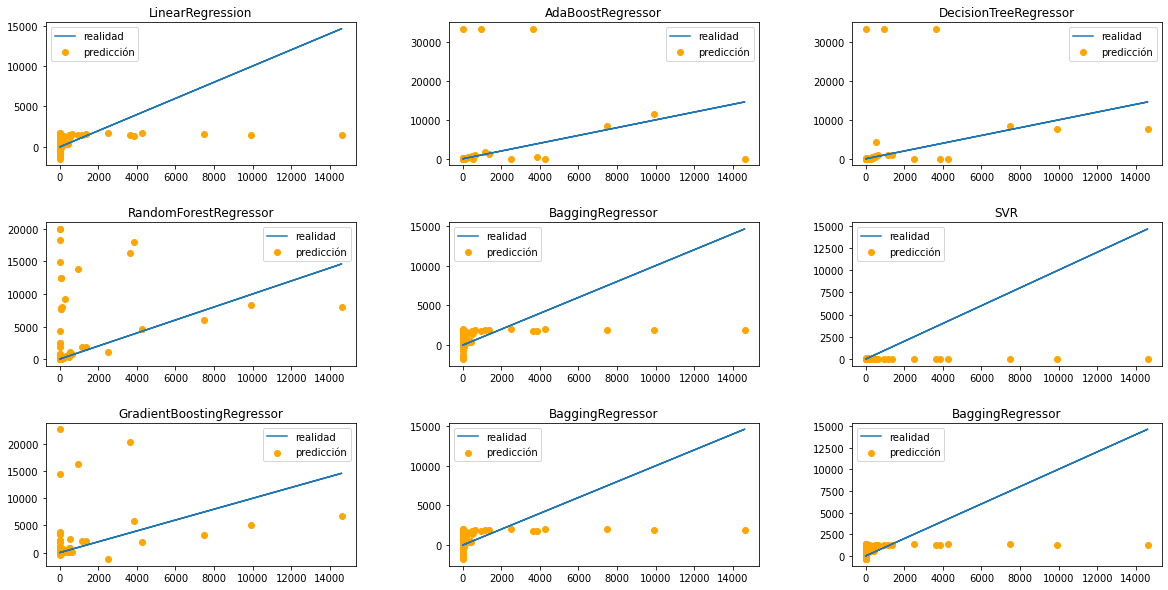

In [208]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,
                                hspace=0.4,figsize=(20,10),columnas=3)

Para el cluster 1 todavía no podemos decidir sobre que algoritmo vamos a usar porque los datos son realmente malos.

# SELECCIÓN DE VARIABLES PARA EL CLUSTER 1
### Modelo Cluster 1: variables mediante Correlación 

Hemos revisado diferentes alternativas, entre ellas:
* usar powertransformer, que vuelve las variables más parecidas a una distribución Gaussiana, quitando los valores extremos, que no eran muchos.
* usar RobustScaler quitando igualmente los valores extremos.
* RobustScaler sin quitar los valores extremos  

Como RobustScaler scaler centra y escala los datos usando la mediana y el rango intercuartílico, y como en este dataset tenemos algunos datos extremos, hemos pensado que sería una buena opción para normalizar los datos ya que estos datos tan altos afectan negativamente a las medias y la varianza. Al final la tercera opción ha sido la que arroja unos resultados más normales. De esta manera, la opción de variables mediante correlación es mala de todas formas posibles, pues en este grupo todas las variables tienen poca correlación con la eficiencia ,y por tanto solo nos quedaron dos variables a usar. En las demás opciones tenemos estimadores que tienen resultados normales y otros que obtienen valores de r2 iguales a 1 y de 0 en las métricas de errores, por lo que no son estimadores a tener en cuenta.

In [209]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,1,var_corr_1,RobustScaler())

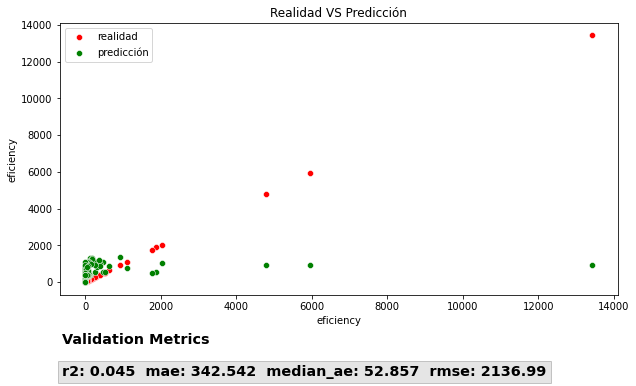

(                                                r2         mae  median_mae
 BaggingRegressor(base_estimator=ElasticN  0.056595  311.600054   58.727994
 LinearRegression()                        0.046315  337.943372   47.901504
 BaggingRegressor(base_estimator=Ridge(),  0.022316  320.886228   45.428457
 BaggingRegressor(base_estimator=Lasso(),  0.009071  335.069721   44.953735
 SVR(kernel='linear')                      0.001306  174.308963    0.100000
 RandomForestRegressor(random_state=0)    -1.868409  315.375102    0.000000
 GradientBoostingRegressor(random_state=0 -2.887267  318.715425    1.048826
 AdaBoostRegressor(base_estimator=Decisio -3.907325  339.571720    0.000000
 DecisionTreeRegressor(random_state=0)    -5.590853  316.605501    0.000000,
 None)

In [210]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

Después de realizar el crossvalidation con 10 folds, tres veces, en ninguna de ella hemos conseguido buenos resultados, por lo que al obtener valores negativos y muy bajos de r2 entendemos que la combinación de variables para este cluster no es adecuada. De hecho, la predicción sigue un patrón totalmente diferente a la realidad y por tanto no vamos a seguir con el estudio de este conjunto de variables, quedando descartado.

### Modelo Cluster 1: variables mediante Vif

In [211]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,1,var_vif_1,RobustScaler())

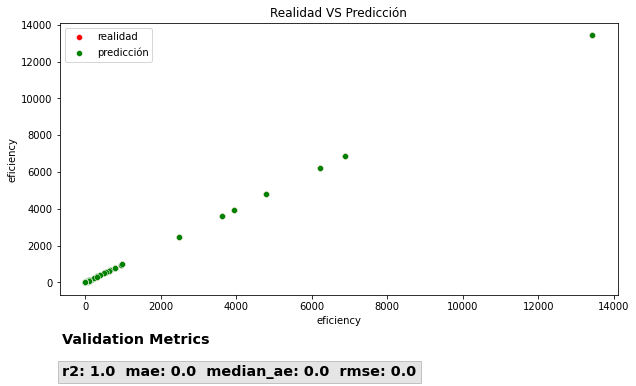

(                                                r2           mae    median_mae
 LinearRegression()                        1.000000  4.091208e-13  1.353102e-13
 BaggingRegressor(base_estimator=Ridge(),  1.000000  1.008552e-07  3.555685e-08
 BaggingRegressor(base_estimator=Lasso(),  1.000000  1.468870e-04  7.627697e-05
 BaggingRegressor(base_estimator=ElasticN  1.000000  1.400255e-04  8.379248e-05
 SVR(kernel='linear')                      1.000000  9.962493e-02  9.999662e-02
 GradientBoostingRegressor(random_state=0  0.846528  1.047475e+01  7.561156e-02
 DecisionTreeRegressor(random_state=0)     0.833731  1.713162e+01  0.000000e+00
 RandomForestRegressor(random_state=0)     0.819762  1.575995e+01  0.000000e+00
 AdaBoostRegressor(base_estimator=Decisio  0.818769  1.275266e+01  0.000000e+00,
 None)

In [212]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

Con el conjunto de variables mediante vif vemos que varios de los estimadores son capaces de obtener resultados perfectos, y de ahí que una de ellas sea la representada en el gráfico, dado que la función representa el que mejor r2 tiene de manera automática. Sin embargo, vemos más acertado y coherente los resultados de GradientBoosting hacia abajo que no explican la variabilidad de la variable dependiente en su totalidad y tienen valores bajos de error. Además, en los estimadores perfectos tanto las métricas de validation como las de test coinciden, veamos como se comporta Gradient en esta comparación:

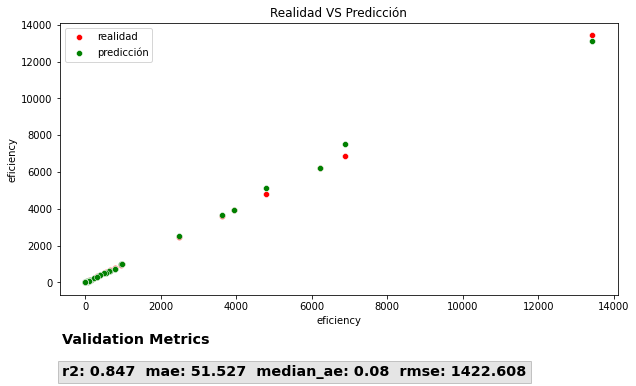

In [213]:
Predicting.cross_val_regression(GradientBoostingRegressor(),x_train,y_train,
                                x_test,y_test)

Vemos que las métricas del validation y el test son coherentes y por tanto podemos esperar desviaciones en nuestras predicciones de esta magnitud.

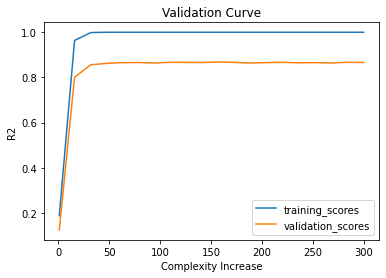

In [214]:
Predicting.val_curve_plot(dfc,GradientBoostingRegressor(),var_vif_1,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [215]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['squared_error','absolute_error','huber','quantile']
        }

best_estim = Predicting.hiper_tune(GradientBoostingRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_vif1 = best_estim

best params: {'n_estimators': 95, 'loss': 'squared_error'}
best score: 0.8476141450227636


Lo ha mejorado poco respecto del último cross validation, incluso el primero era algo mejor con los valores por defecto, por lo que vamos a probar con más hiperparámteros:

In [216]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['squared_error','absolute_error','huber','quantile'],
        "criterion":['friedman_mse','squared_error'],
        "max_features":[1.0,"sqrt","log2"],
        "max_depth": np.arange(1,11),
        "min_samples_leaf": np.arange(1,11),
        "alpha":np.arange(0.001,0.999)
        }

best_estim = Predicting.hiper_tune(GradientBoostingRegressor(),params,
                                                x_train,y_train,"r2")
best_estim_vif1_2 = best_estim

best params: {'n_estimators': 126, 'min_samples_leaf': 9, 'max_features': 1.0, 'max_depth': 10, 'loss': 'absolute_error', 'criterion': 'squared_error', 'alpha': 0.001}
best score: 0.7522391763588581


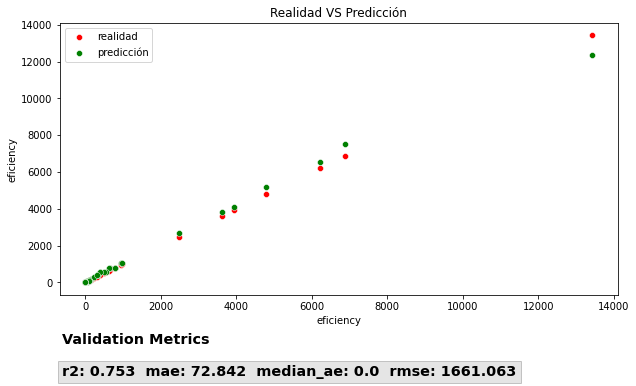

In [217]:
Predicting.cross_val_regression(best_estim_vif1_2,x_train,y_train,x_test,y_test)

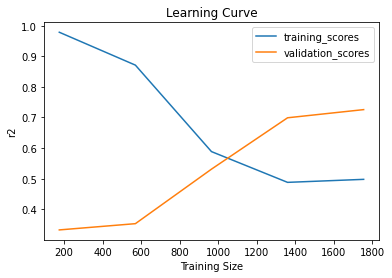

In [218]:
Predicting.learn_curve_plot(dfc,var_vif_1,best_estim_vif1_2,"r2")

Podemos apreciar que con más datos este modelo sería posible mejorarlo pues no llega a converger del todo con el training la curva de validation.

### Modelo Cluster 1: variables mediante OLS de Statsmodels

In [219]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,1,ols_vars_cl1,RobustScaler())

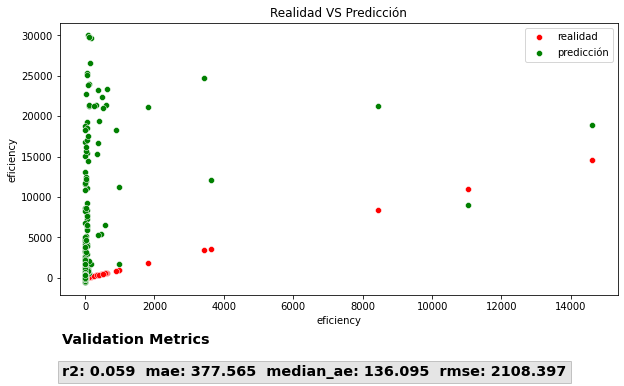

(                                                r2         mae  median_mae
 BaggingRegressor(base_estimator=Lasso(),  0.071670  361.070063  148.593390
 BaggingRegressor(base_estimator=ElasticN  0.070904  343.916396  118.730573
 SVR(kernel='linear')                      0.005151  162.886306    0.050937
 BaggingRegressor(base_estimator=Ridge(), -0.003535  368.410143  146.114427
 LinearRegression()                       -0.105923  363.221243  137.009756
 RandomForestRegressor(random_state=0)    -1.255981  154.537570    0.000000
 GradientBoostingRegressor(random_state=0 -3.064491  176.688071    8.515834
 DecisionTreeRegressor(random_state=0)    -5.537123  142.669744    0.000000
 AdaBoostRegressor(base_estimator=Decisio -7.449723  137.282379    0.000000,
 None)

In [220]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

Al igual que con las variables de correlación no seguiremos realizando el estudio de las variables mediante ols dado que los resultados no son buenos después de varios intentos en el cross validation. Podemos apreciar en el gráfico que nada tiene que ver la realidad con la predicción por lo que esta combinación no funciona para predecir los datos de este cluster.

### Modelo Cluster 1: variables mediante RFECV

In [221]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,1,rfecv_vars_1,RobustScaler())

In [222]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

c:\Users\ferna\miniconda3\envs\the_bridge_22\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e+06, tolerance: 7.317e+05

c:\Users\ferna\miniconda3\envs\the_bridge_22\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e+07, tolerance: 6.358e+05

c:\Users\ferna\miniconda3\envs\the_bridge_22\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.715e+07, tolerance: 1.800e+06

c:\User

Al igual que con la selección mediante correlación y ols, no seguimos con el estudio debido a que los modelos no son capaces de expicar la variabilidad de la variable dependiente en repetidas pruebas.  
En este cluster los modelos seleccionados mediante correlación, ols y rfecv han sido descartados directamente puesto que las métricas obtenidas eran malas. Los modelos no eran capaces de explicar la variabilidad de los datos del grupo y no generalizaba bien. En el modelo conformado por las variables obtenidas mediante vif se han descartado aquellos que obtenían una predicción perfecta sin error, y han quedado como candidatos a seleccionar, con datos normales los siguientes estimadores:

* AdaBoost-DecisionTree
* DecisionTree
* RandomForest
* GradientBoostingRegressor

De todos ellos ha sido seleccionado GradientBoostRegressor por tener el mejor valor de R2 de mae y de rmse. Las variables que caracterizan este modelo son:  
`['Population',
 'GDP',
 'CO2_emission',
 'eficiency',
 'per_capita_production',
 'energy_dependecy',
 'Energy_intensity_by_GDP',
 'use_intensity_pc',
 'Energy_production',
 'co2_pc',
 'balance']`

In [ ]:
# Guardamos el modelo para el cluster 1:
reg_cluster1 = best_estim_vif1_2
reg_cluster1fit = reg_cluster1.fit(x_train,y_train)
gp.models_saver(reg_cluster1fit,"reg_cluster1")

Modelo guardado correctamente


Para el cluster 2:

In [ ]:
# Dividimos el dataframe:
y = df[df.clusters==2].eficiency
X = df2[[x for x in df2.columns if x not in ["eficiency","clusters"]]]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

In [ ]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

In [ ]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

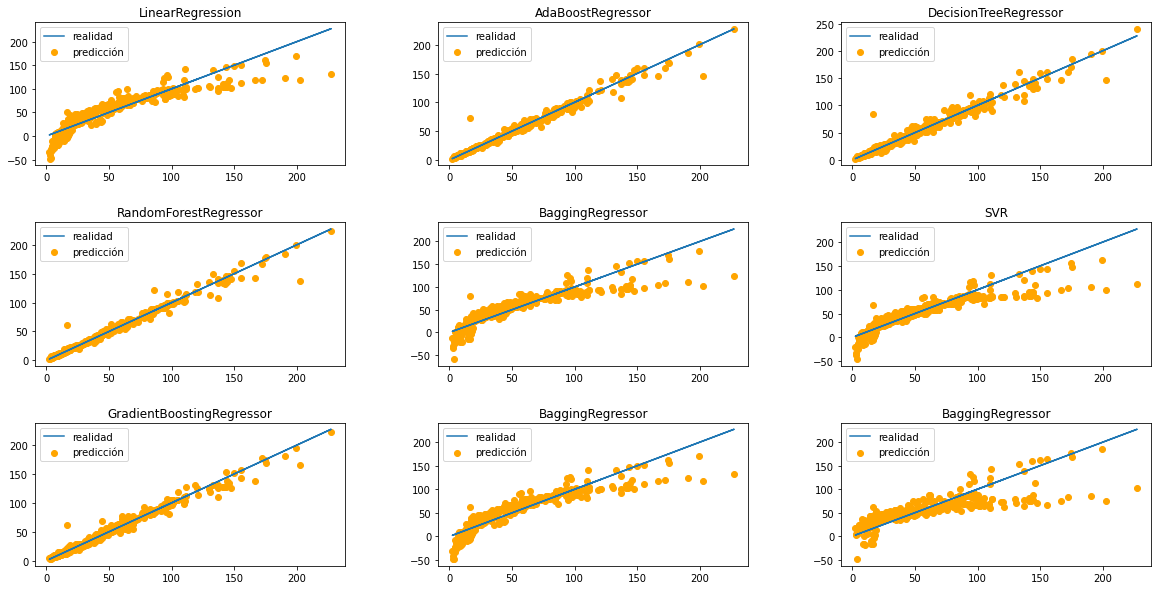

In [ ]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,
                                hspace=0.4,figsize=(20,10),columnas=3)

Para el cluster 2 el mejor estimador ha sido AdaBoost con Decision Tree al tener el mejor dato de mean squared error, mean absolute error y estar prácticamente al mismo nivel de r2 que el mejor de todos que ha sido GradientBoosting.

# SELECCIÓN DE VARIABLES PARA EL CLUSTER 2
### Modelo Cluster 2: variables mediante Correlación 

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,2,var_corr_2,PowerTransformer())

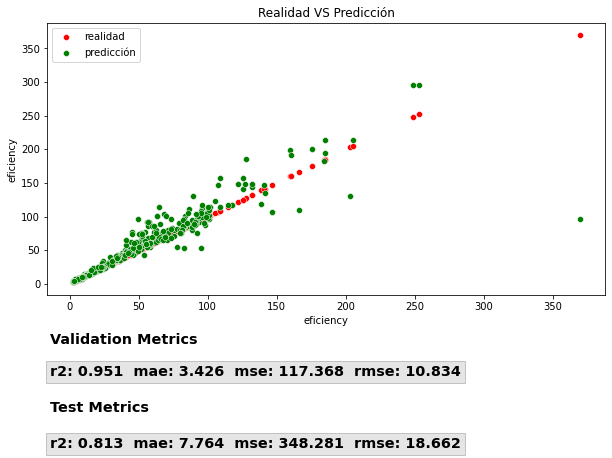

(                                                r2        mae       rmse
 AdaBoostRegressor(base_estimator=Decisio  0.942333   3.553624   9.544531
 RandomForestRegressor(random_state=0)     0.937508   4.156537  10.769413
 GradientBoostingRegressor(random_state=0  0.923392   5.966752  11.654058
 DecisionTreeRegressor(random_state=0)     0.884124   5.165090  14.334212
 BaggingRegressor(base_estimator=Ridge(),  0.627203  17.155130  26.014429
 LinearRegression()                        0.626956  17.191231  26.027616
 BaggingRegressor(base_estimator=Lasso(),  0.612096  17.442261  26.528624
 SVR(kernel='linear')                      0.590759  16.115364  27.304768
 BaggingRegressor(base_estimator=ElasticN  0.564021  19.011570  28.122904,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

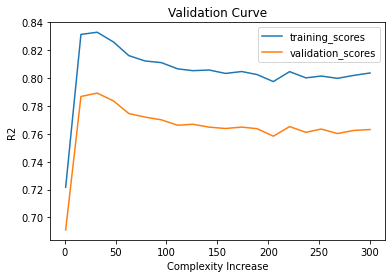

In [ ]:
Predicting.val_curve_plot(dfc,AdaBoostRegressor(),var_corr_2,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "learning_rate": np.linspace(0.001,0.99,20,dtype=float),
        "loss":['linear','square','exponential'],
        "base_estimator":[DecisionTreeRegressor(),Lasso(),Ridge(),ElasticNet()]
        }

best_estim = Predicting.hiper_tune(AdaBoostRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_cor2 = best_estim

best params: {'n_estimators': 174, 'loss': 'linear', 'learning_rate': 0.7817894736842106, 'base_estimator': DecisionTreeRegressor()}
best score: 0.9564126790753601


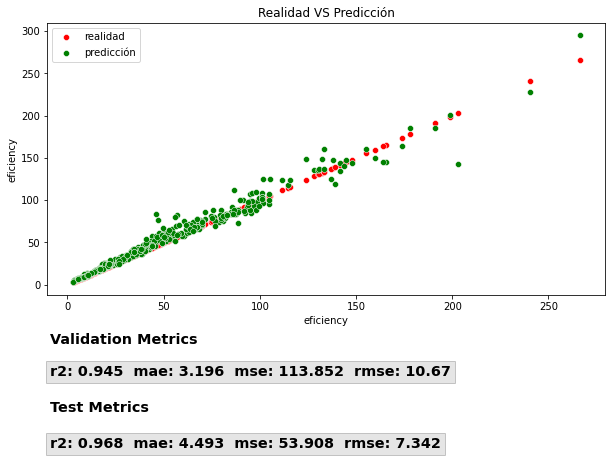

In [ ]:
Predicting.cross_val_regression(best_estim_cor2,x_train,y_train,x_test,y_test)

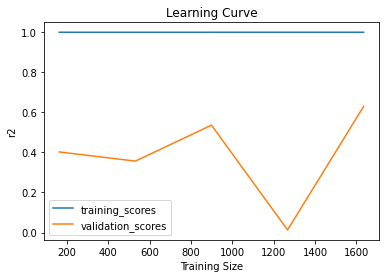

In [ ]:
Predicting.learn_curve_plot(dfc,var_corr_2,best_estim_cor2,"r2")

### Modelo Cluster 2: variables mediante Vif

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,2,var_vif_2,PowerTransformer())

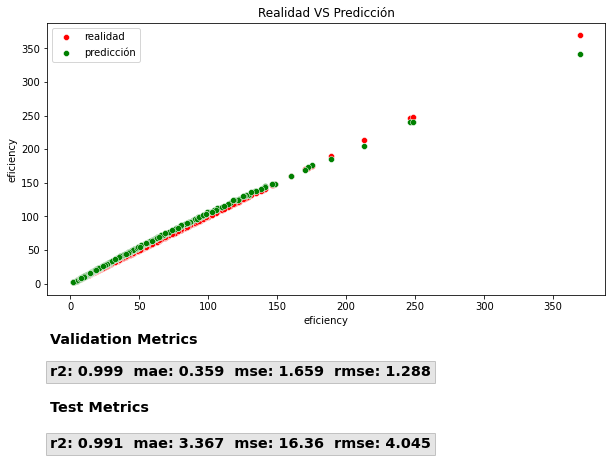

(                                                r2        mae       rmse
 GradientBoostingRegressor(random_state=0  0.999257   0.365761   0.908582
 RandomForestRegressor(random_state=0)     0.999202   0.198774   1.037970
 AdaBoostRegressor(base_estimator=Decisio  0.998713   0.216663   1.454798
 DecisionTreeRegressor(random_state=0)     0.998133   0.302012   1.632576
 LinearRegression()                        0.866348  10.862979  15.585676
 BaggingRegressor(base_estimator=Ridge(),  0.865955  10.840010  15.582757
 BaggingRegressor(base_estimator=Lasso(),  0.863593  10.729720  15.787941
 SVR(kernel='linear')                      0.838125   9.556354  17.146662
 BaggingRegressor(base_estimator=ElasticN  0.777146  12.950323  20.157476,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

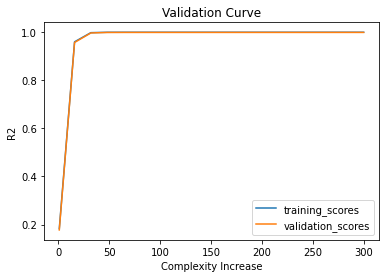

In [ ]:
Predicting.val_curve_plot(dfc,GradientBoostingRegressor(),var_vif_2,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

se aprecia que está ligeramente por debajo por lo que en este caso han convergido bastante bien. De esta manera no consideramos que sea necesario un hiperparameter tuning.

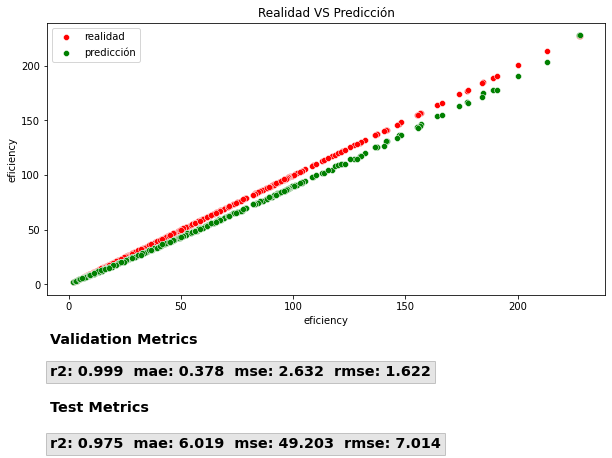

In [ ]:
best_estim_vif2 = GradientBoostingRegressor()
Predicting.cross_val_regression(best_estim_vif2,x_train,y_train,x_test,y_test)

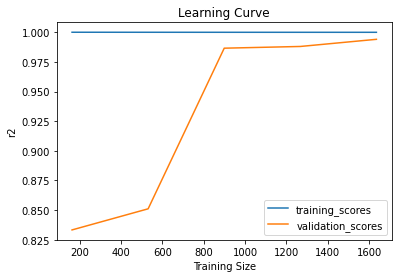

In [ ]:
Predicting.learn_curve_plot(dfc,var_vif_2,best_estim_vif2,"r2")

aquí podemos apreciar que no son necesarios más datos, pues las curvas convergen hacia el final de las mismas

### Modelo Cluster 2: variables mediante Rfecv

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,2,rfecv_vars_2,PowerTransformer())

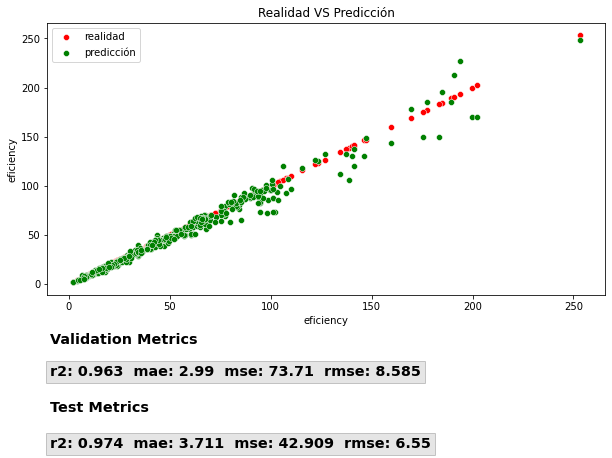

(                                                r2        mae       rmse
 AdaBoostRegressor(base_estimator=Decisio  0.962698   3.015217   7.541345
 RandomForestRegressor(random_state=0)     0.959677   3.117563   7.918243
 GradientBoostingRegressor(random_state=0  0.957050   4.307205   8.582674
 DecisionTreeRegressor(random_state=0)     0.932448   3.953451   9.723584
 BaggingRegressor(base_estimator=Lasso(),  0.758781  12.747995  21.142155
 BaggingRegressor(base_estimator=Ridge(),  0.753331  12.992654  21.305611
 LinearRegression()                        0.752636  13.038000  21.351520
 SVR(kernel='linear')                      0.739929  11.366009  22.177764
 BaggingRegressor(base_estimator=ElasticN  0.681632  14.928147  24.483362,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

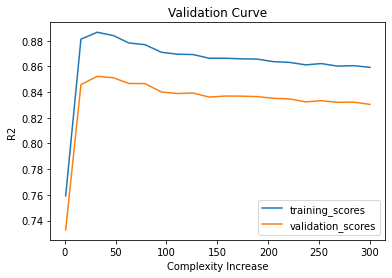

In [ ]:
Predicting.val_curve_plot(dfc,AdaBoostRegressor(),rfecv_vars_2,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "learning_rate": np.linspace(0.001,0.99,20,dtype=float),
        "loss":['linear','square','exponential'],
        "base_estimator":[DecisionTreeRegressor(),Lasso(),Ridge(),ElasticNet()]
        }

best_estim = Predicting.hiper_tune(AdaBoostRegressor(),params,
                                        x_train,y_train,"r2")
best_estim
best_estim_rfecv2 =  best_estim

best params: {'n_estimators': 79, 'loss': 'square', 'learning_rate': 0.3653684210526316, 'base_estimator': DecisionTreeRegressor()}
best score: 0.9849241252009451


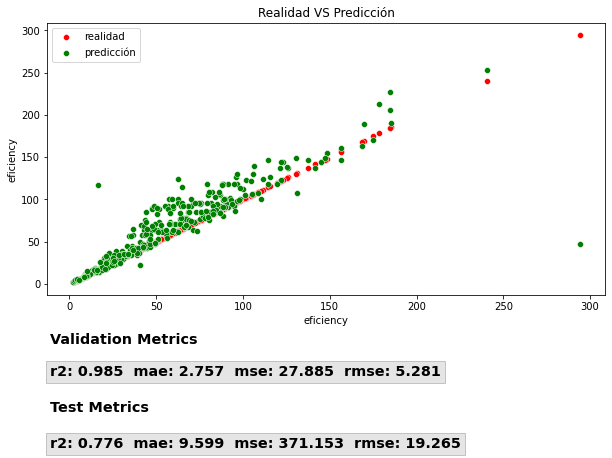

In [ ]:
Predicting.cross_val_regression(best_estim_rfecv2,x_train,y_train,x_test,y_test)

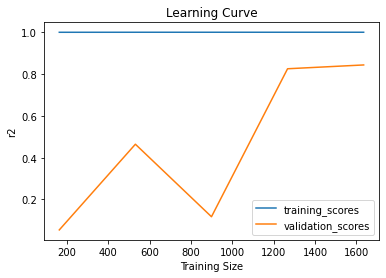

In [ ]:
Predicting.learn_curve_plot(dfc,rfecv_vars_2,best_estim_rfecv2,"r2")

Con esta convinación de variables el algoritmo podría mejorar si tenemos más datos, pues no termina de converger.

### Modelo Cluster 2: variables mediante OLS

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,2,ols_vars_cl2,PowerTransformer())

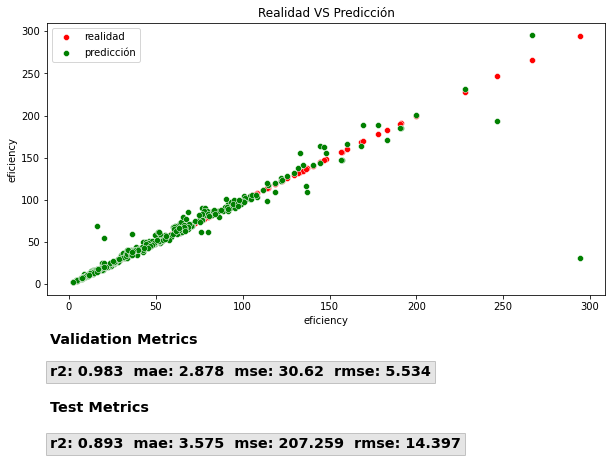

(                                                r2        mae       rmse
 AdaBoostRegressor(base_estimator=Decisio  0.982338   2.841967   5.681659
 RandomForestRegressor(random_state=0)     0.979444   2.924634   6.013608
 GradientBoostingRegressor(random_state=0  0.977797   3.974287   6.302884
 DecisionTreeRegressor(random_state=0)     0.936425   3.960612   9.473081
 LinearRegression()                        0.810383  12.200273  18.482902
 BaggingRegressor(base_estimator=Ridge(),  0.809009  12.231440  18.524338
 BaggingRegressor(base_estimator=Lasso(),  0.799967  11.745361  18.947809
 SVR(kernel='linear')                      0.775016  10.765273  20.031818
 BaggingRegressor(base_estimator=ElasticN  0.711990  14.296399  22.876202,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

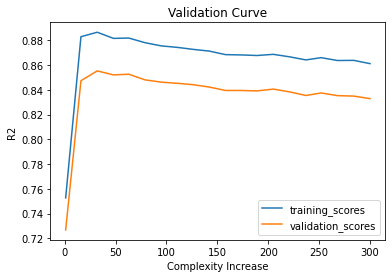

In [ ]:
Predicting.val_curve_plot(dfc,AdaBoostRegressor(),ols_vars_cl2,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "learning_rate": np.linspace(0.001,2,20,dtype=float),
        "loss":['linear','square','exponential'],
        "base_estimator":[DecisionTreeRegressor(),Lasso(),Ridge(),ElasticNet()]
        }

best_estim_ols2 = Predicting.hiper_tune(AdaBoostRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_ols2

best params: {'n_estimators': 142, 'loss': 'square', 'learning_rate': 0.8426842105263158, 'base_estimator': DecisionTreeRegressor()}
best score: 0.9631712592922617


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                  learning_rate=0.8426842105263158, loss='square',
                  n_estimators=142)

Con AdaBoost no conseguimos mejorar el resultado base después de varios intentos pero comprobamos de manera empírica que el estimador tuneado obtiene resultados más consistentes entre el validation y el test de manera recurrente, por lo que nos quedamos con él. 

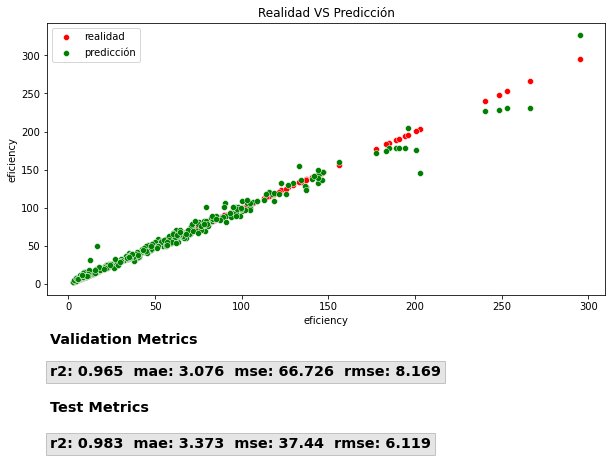

In [ ]:
Predicting.cross_val_regression(best_estim_ols2,x_train,y_train,x_test,y_test)

Es posible ver variaciones en las predicciones de la magnitud vista entre el validation y el tes

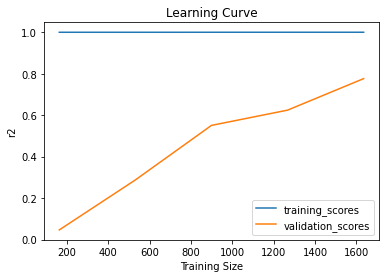

In [ ]:
Predicting.learn_curve_plot(dfc,ols_vars_cl2,best_estim_ols2,"r2")

Sería posible mejorar los resultados si aumentamos el número de observaciones, ya que están bastante lejos de converger las curvas.

Para cada modelo las mejores métricas han sido:

|estimador|R2|Mae|Rmse|n_variables|
|---------|--|---|----|-----------|
|<mark>RandomForest-Correlación</mark>|0.945|3.196|10.67|5|
|GBR-Vif|0.999|0.378|1.622|8|
|Ada-Rfecv|0.985|2.757|5.281|6|
|Ada-ols|0.982|2.866|5.642|12|

de los cuales hemos elegido:
$$\text{Gradient Boosting Regresor con las variables de variation inflactor factor}$$
ya que tiene el mejor compromiso complejidad-métricas, pues con 8 variables, obtiene los datos con menor variación entre cross validation y test, tanto en el inicio, validation, y después en la fase de hiperparameter tuning. Además, según podemos ver en la validation curve, con la complejidad data en gradient boosting el modelo converge con el training perfectamente y no es necesario añadir más datos para tener un buen modelo como vemos en la learning curve. Por el contrario, los otros modelos, aunque obtienen tambíen buenas métricas tienen una mayor dispersión entre las métricas del validation y del test. Por otra parte, las validation curve no llegan ha acercarse y conforme aumenta la complejidad tienden a decrecer, lo que indica que Ada no lo puede hacer mejor y para aumentar los resultados con esas variables sería necesario utilizar otro estimador. Teniendo en cuenta las learning curve no llegan a converger en ningún momento por lo que nos indica que estos modelos necesitan más datos para poder mejorar.

In [ ]:
# Guardamos el modelo para el cluster 2:
reg_cluster2 = best_estim_vif2
reg_cluster2fit = reg_cluster2.fit(x_train,y_train)
gp.models_saver(reg_cluster2fit,"reg_cluster2")

Modelo guardado correctamente


Para el cluster 3:

In [ ]:
# Dividimos el dataframe:
y = df[df.clusters==3].eficiency
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

In [ ]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

In [ ]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

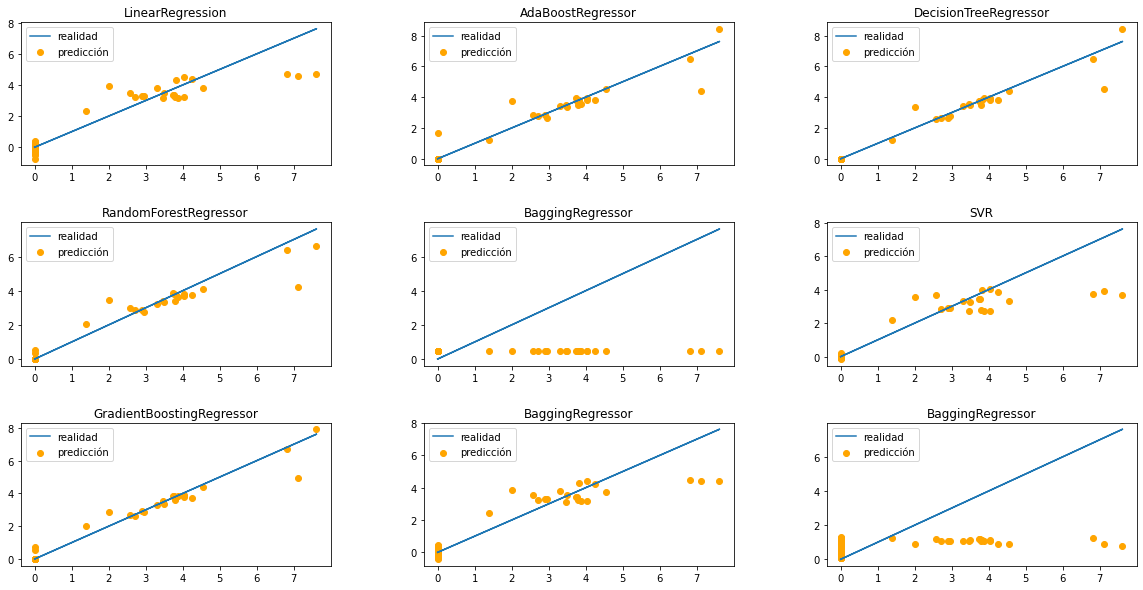

In [ ]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,
                                hspace=0.4,figsize=(20,10),columnas=3)

Para el cluster 3, claramente el mejor estimador es GradientBoostingRegressor usando todas las variables.

# SELECCIÓN DE VARIABLES PARA EL CLUSTER 3
### Modelo Cluster 3: variables mediante Correlación 

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,3,var_corr_3,PowerTransformer())

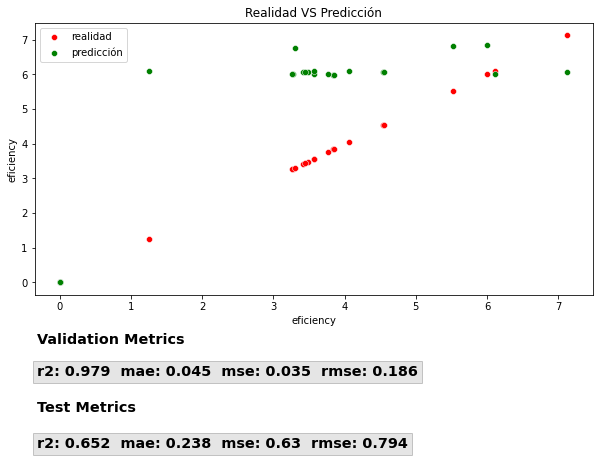

(                                                r2       mae      rmse
 RandomForestRegressor(random_state=0)     0.980695  0.045157  0.185418
 GradientBoostingRegressor(random_state=0  0.980615  0.042658  0.156494
 AdaBoostRegressor(base_estimator=Decisio  0.975630  0.047920  0.183234
 DecisionTreeRegressor(random_state=0)     0.970752  0.056567  0.226427
 BaggingRegressor(base_estimator=Ridge(),  0.872064  0.129772  0.454827
 LinearRegression()                        0.871504  0.128799  0.465172
 SVR(kernel='linear')                      0.868239  0.162280  0.471865
 BaggingRegressor(base_estimator=ElasticN  0.576978  0.488177  0.843693
 BaggingRegressor(base_estimator=Lasso(),  0.270546  0.680090  1.112100,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

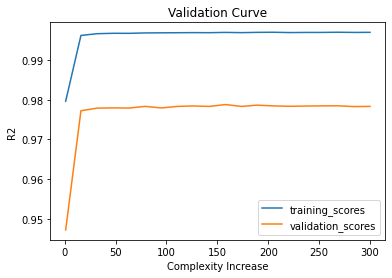

In [ ]:
Predicting.val_curve_plot(dfc,RandomForestRegressor(),var_corr_3,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "criterion":['squared_error','absolute_error','poisson'],
        "max_features":[1.0,'sqrt','log2']
        }

best_estim_corr3 = Predicting.hiper_tune(RandomForestRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_corr3


best params: {'n_estimators': 126, 'max_features': 1.0, 'criterion': 'squared_error'}
best score: 0.9808770874263361


RandomForestRegressor(n_estimators=126)

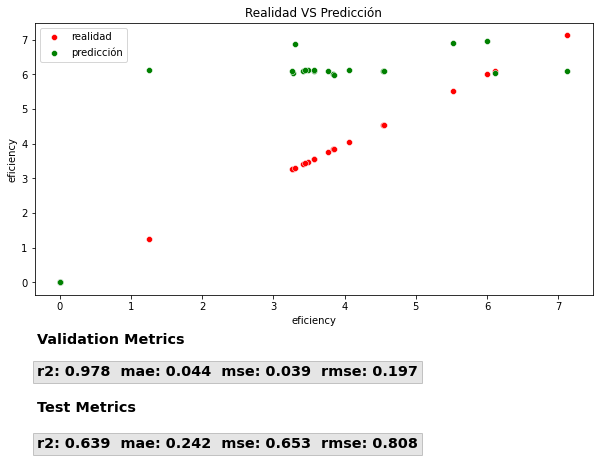

In [ ]:
Predicting.cross_val_regression(best_estim_corr3,x_train,y_train,x_test,y_test)

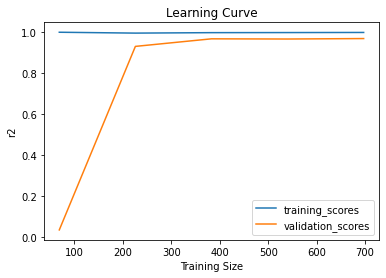

In [ ]:
Predicting.learn_curve_plot(dfc,var_corr_3,best_estim_corr3,"r2")

### Modelo Cluster 3: variables mediante Vif

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,3,var_vif_3,PowerTransformer())

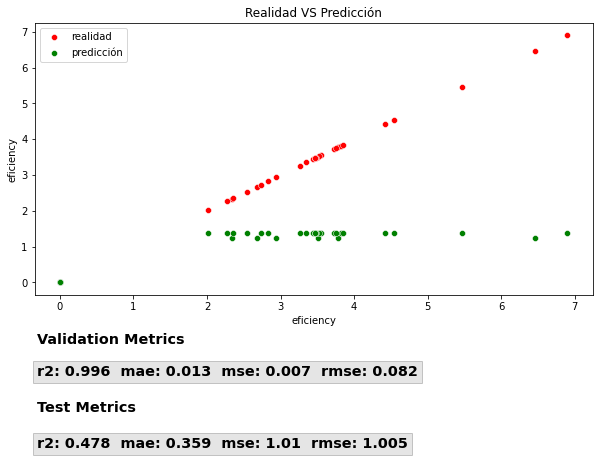

(                                                r2       mae      rmse
 GradientBoostingRegressor(random_state=0  0.995644  0.012447  0.076214
 RandomForestRegressor(random_state=0)     0.994379  0.015469  0.091397
 AdaBoostRegressor(base_estimator=Decisio  0.993919  0.015367  0.086081
 DecisionTreeRegressor(random_state=0)     0.992608  0.018688  0.102049
 SVR(kernel='linear')                      0.871385  0.147660  0.463448
 BaggingRegressor(base_estimator=Ridge(),  0.870243  0.153569  0.462787
 LinearRegression()                        0.864745  0.157230  0.465238
 BaggingRegressor(base_estimator=ElasticN  0.561016  0.470555  0.850677
 BaggingRegressor(base_estimator=Lasso(),  0.250421  0.651702  1.109475,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

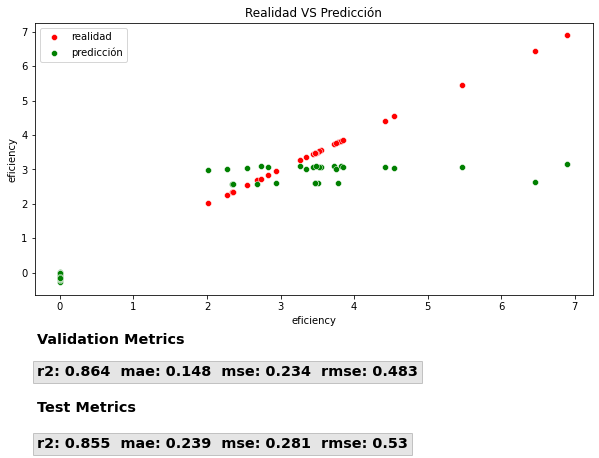

In [ ]:
Predicting.cross_val_regression(SVR(kernel="linear"),x_train,y_train,x_test,y_test)

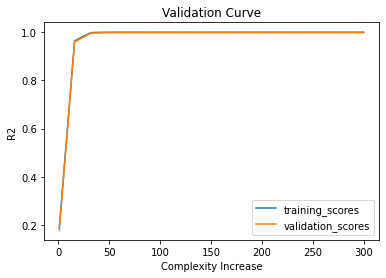

In [ ]:
Predicting.val_curve_plot(dfc,GradientBoostingRegressor(),var_vif_3,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['squared_error','absolute_error','huber','quantile'],
        "criterion":['friedman_mse','squared_error'],
        "max_features":[1.0,"sqrt","log2"],
        "max_depth": np.arange(1,11),
        "min_samples_leaf": np.arange(1,11),
        "alpha":np.arange(0.001,0.999)
        }
best_estim_vif3 = Predicting.hiper_tune(GradientBoostingRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_vif3

best params: {'n_estimators': 95, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 9, 'loss': 'squared_error', 'criterion': 'squared_error', 'alpha': 0.001}
best score: 0.9769677876262485


GradientBoostingRegressor(alpha=0.001, criterion='squared_error', max_depth=9,
                          max_features='log2', min_samples_leaf=5,
                          n_estimators=95)

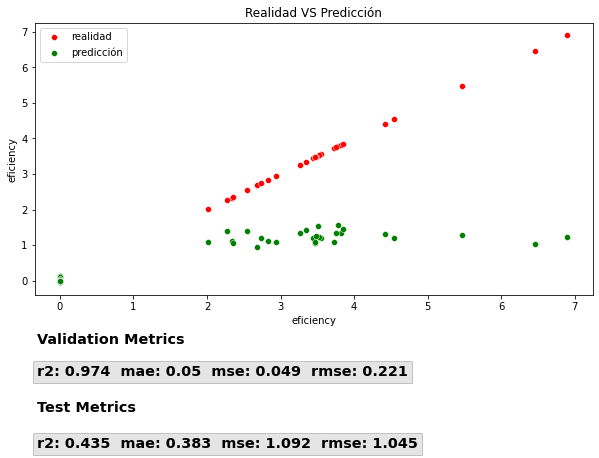

In [ ]:
Predicting.cross_val_regression(best_estim_vif3,x_train,y_train,x_test,y_test)

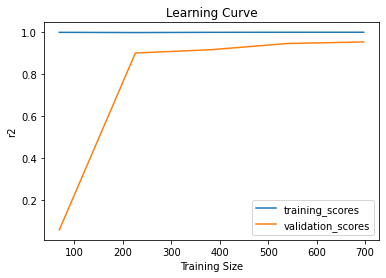

In [ ]:
Predicting.learn_curve_plot(dfc,var_vif_3,best_estim_vif3,"r2")

### Modelo Cluster 3: variables mediante Rfecv

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,3,rfecv_vars_3,PowerTransformer())

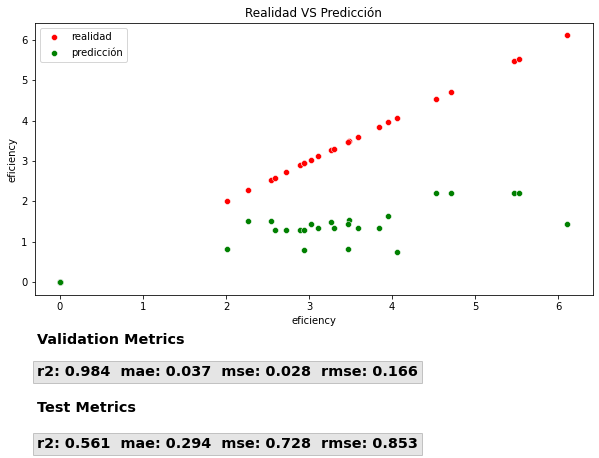

(                                                r2       mae      rmse
 GradientBoostingRegressor(random_state=0  0.985772  0.034439  0.150611
 RandomForestRegressor(random_state=0)     0.977342  0.041621  0.185838
 AdaBoostRegressor(base_estimator=Decisio  0.976905  0.043997  0.184672
 DecisionTreeRegressor(random_state=0)     0.969922  0.050770  0.210232
 LinearRegression()                        0.871064  0.136407  0.467897
 BaggingRegressor(base_estimator=Ridge(),  0.870516  0.138281  0.466268
 SVR(kernel='linear')                      0.870391  0.152298  0.461176
 BaggingRegressor(base_estimator=ElasticN  0.555149  0.492985  0.870399
 BaggingRegressor(base_estimator=Lasso(),  0.287618  0.665808  1.112216,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

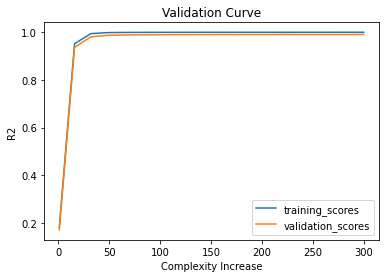

In [ ]:
Predicting.val_curve_plot(dfc,GradientBoostingRegressor(),rfecv_vars_3,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['squared_error','absolute_error','huber','quantile'],
        "criterion":['friedman_mse','squared_error'],
        "max_features":[1.0,"sqrt","log2"],
        "max_depth": np.arange(1,11),
        "min_samples_leaf": np.arange(1,11),
        "alpha":np.arange(0.001,0.999)
        }

best_estim_rfecv3 = Predicting.hiper_tune(GradientBoostingRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_rfecv3

best params: {'n_estimators': 300, 'min_samples_leaf': 6, 'max_features': 1.0, 'max_depth': 10, 'loss': 'absolute_error', 'criterion': 'squared_error', 'alpha': 0.001}
best score: 0.9838207885354755


GradientBoostingRegressor(alpha=0.001, criterion='squared_error',
                          loss='absolute_error', max_depth=10, max_features=1.0,
                          min_samples_leaf=6, n_estimators=300)

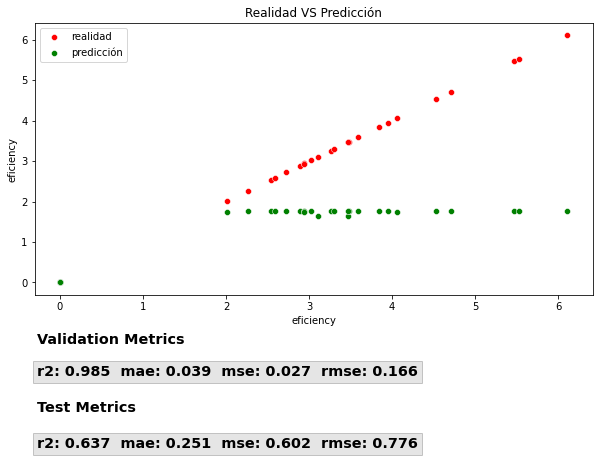

In [ ]:
Predicting.cross_val_regression(best_estim_rfecv3,x_train,y_train,x_test,y_test)

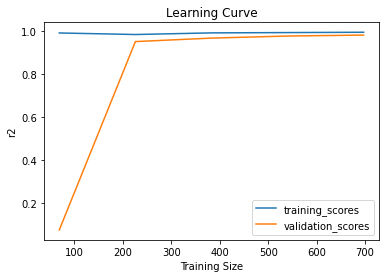

In [ ]:
Predicting.learn_curve_plot(dfc,rfecv_vars_3,best_estim_rfecv3,"r2")

### Modelo Cluster 3: variables mediante OLS

In [ ]:
dfc,x_train,x_test,y_train,y_test = Predicting.dataset(df,3,ols_vars_cl3,PowerTransformer())

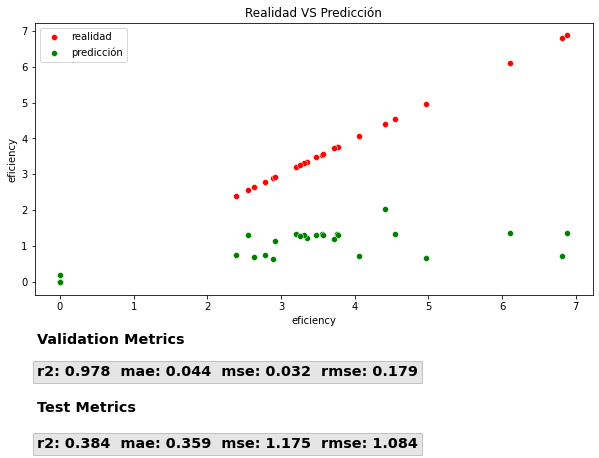

(                                                r2       mae      rmse
 GradientBoostingRegressor(random_state=0  0.981370  0.044269  0.170911
 RandomForestRegressor(random_state=0)     0.968148  0.052327  0.213855
 AdaBoostRegressor(base_estimator=Decisio  0.967431  0.053935  0.213378
 DecisionTreeRegressor(random_state=0)     0.957664  0.057454  0.245582
 BaggingRegressor(base_estimator=Ridge(),  0.876772  0.154530  0.449112
 LinearRegression()                        0.874034  0.155112  0.451929
 SVR(kernel='linear')                      0.873040  0.148138  0.453725
 BaggingRegressor(base_estimator=ElasticN  0.571213  0.478028  0.842990
 BaggingRegressor(base_estimator=Lasso(),  0.275249  0.663553  1.099343,
 None)

In [ ]:
Predicting.ml_selector(dfc,x_train,x_test,y_train,y_test,lista_estimadores)

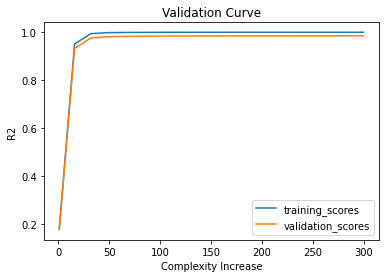

In [ ]:
Predicting.val_curve_plot(dfc,GradientBoostingRegressor(),ols_vars_cl3,
                        "n_estimators",np.linspace(1,300,20,dtype=int))

In [ ]:
params = {
        "n_estimators":np.linspace(1,300,20,dtype=int),
        "loss":['squared_error','absolute_error','huber','quantile'],
        "criterion":['friedman_mse','squared_error'],
        "max_features":[1.0,"sqrt","log2"],
        "max_depth": np.arange(1,11),
        "min_samples_leaf": np.arange(1,11),
        "alpha":np.arange(0.001,0.999)
        }

best_estim_ols3 = Predicting.hiper_tune(GradientBoostingRegressor(),params,
                                        x_train,y_train,"r2")
best_estim_ols3

best params: {'n_estimators': 126, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 4, 'loss': 'squared_error', 'criterion': 'friedman_mse', 'alpha': 0.001}
best score: 0.9836352842065219


GradientBoostingRegressor(alpha=0.001, max_depth=4, max_features=1.0,
                          n_estimators=126)

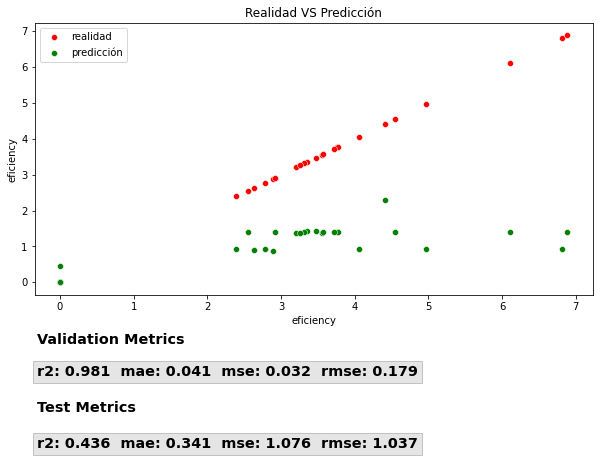

In [ ]:
Predicting.cross_val_regression(best_estim_ols3,x_train,y_train,x_test,y_test)

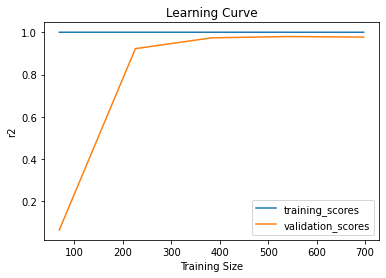

In [ ]:
Predicting.learn_curve_plot(dfc,ols_vars_cl3,best_estim_ols3,"r2")

Teniendo en cuenta los mejores estimadores para cada método de selección de variables:

|estimador|R2|Mae|Rmse|n_variables|
|---------|--|---|----|-----------|
|GradientBoostingRegressor-Correlación|0.986|0.041|0.173|5|
|RandomForest-Vif|0.997|0.011|0.081|9|
|<mark>GradientBoostingRegressor-Rfecv</mark>|0.988|0.037|0.165|4|
|GradientBoostingRegressor-OLS|0.998|0.009|0.06|12|

hemos elegido:
$$\text{GradientBoostingRegressor con las variables de RFECV}$$

por los buenos datos, pues con menos variables lo hace mejor que el resto.


In [ ]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_3]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)

# Guardamos el modelo para el cluster 1:
reg_cluster3 = GradientBoostingRegressor(random_state=0)
reg_cluster3fit = reg_cluster3.fit(x_train,y_train)
gp.models_saver(reg_cluster3fit,"reg_cluster3")

Modelo guardado correctamente


# RESUMEN:

Primeramente hemos dividido el dataframe en clusters y hemos buscado las variables con las que podríamos tener mejores resultados para la predicción mediante 4 métodos:

1. correlación (hemos usado la de spearman debido a que es menos sensible a los valores extremos)
2. vif (Variation inflation factor, que nos dice la multicolinealidad existente en un modelo de multiples variables)
3. RFECV (Recursive Feature Elimination Cross Validation)
4. Ols (mirando la significancia estadística de las variables proporcionada por el regresor, además de aic y bic)

Luego hemos creado un base line general mirando r2,mae y rmse para determinar cual de los estimadores podría ser el mejor para nuestro modelo, usando todas las variables de las que disponemos. Una vez obtenido el baseline hemos intentado mejorarlo probando los diferentes algoritmos con las variables seleccionadas por cada uno de los métodos y los hemos comparado entre ellos, eligiendo el mejor modelo y las mejores variables de entre todos ellos teniendo en cuenta las mismas tres métricas que en el base line. De esta manera las variables y los estimadores elegidos para cada uno de los clusters han sido:

|CLUSTER|ESTIMADOR|VARIABLES|M.ELECCIÓN|
|-------|---------|---------|---------------|
|cluster 0|AdaBoostRegressor(DecisionTree)|['balance', 'Energy_consumption', 'Energy_production', 'CO2_emission']|RFECV y Correlación|
|cluster 1|DecisionTree|['CO2_emission', 'co2_pc', 'per_capita_production', 'Energy_consumption']|RFECV|
|cluster 2|RandomForest|['GDP', 'Population', 'Energy_consumption', 'CO2_emission', 'balance']|Correlación|
|cluster 3|GradientBoostingRegressor|['CO2_emission', 'Energy_production', 'balance', 'Energy_consumption']|RFECV|

Como recordamos al principio nuestro cluster 0 se caracterizaba por contener países que tienen poca producción pero emiten bastantes emisiones de co2, resultando poco eficientes y los menos eficientes de todos. Si relacionamos esta descripción con las variables que caracterizan su modelo podemos ver que tenemos:

+ balance
+ energy_consumption
+ energy_production
+ co2_emission

es decir, las variables que más caracterizan a esta descripción. Al ser países con poca producción y mucha emisión de co2, sabiendo la producción y el co2 podemos saber si cumplen esta cualidad. Además, al ser países que producen poco, son países con un consumo de energía superior a la producción y por tanto con un balance negativo.

Por otra parte, el cluster 1 está representado por países con poca produccción y pocas emisiones de co2 basados en el petróleo, las renovables y el gas natural, siendo los segundos menos eficientes de todos. Las variables que más los caracterizan para predecir su eficiencia han sido:

+ co2_emission
+ co2_pc
+ per_capita_production
+ Energy_consumption

En estos países, pensamos que el modelo ha preferido las variables per capita de las emisiones de co2 y de la producción porque contiene valores más pequeños, dados los valores también pequeños de las emisiones de co2 y la producción en valores absolutos. Aún así, como son países que los caracterizan mucho la pocas emisiones de co2 y el poco consumo de energía, en valores absolutos, el modelo los ha seleccionado como predictores de la eficiencia.

El cluster 2 tiene a los países con mayor producción y mayor emisión de co2 del mundo, muy por encima de los otros cluster, pero siendo los segundos más eficientes de los clusters. Su producción está basada en el carbón, el gas natural y el petróleo. Dada esta descripción, las variables que han caracterizado el modelo de regresión de la eficiencia han sido:

+ GDP
+ Population
+ Energy_consumption
+ CO2_emission
+ balance

Al ser países tan grandes en media y con tanta producción, son países con grandes productos interiores brutos y población. Además, son países que tienen un consumo elevado de energía debido a sus altos niveles de PIB y las emisiones de co2 son las más elevadas, llevando a que tengan balances de energía positivos.

En el cluster 3 nos encontramos a países con las segundas mayores producciones de energía mundiales, que usan todas las fuentes de energía en proporciones similares en media, y sus emisiones de co2 son muy bajas, cercanas al cluster 1 para una producción mucho mayor. Estos países son los más eficientes con diferencia y serían la referencia a seguir. Los países que más se encuentran a lo largo de los años del estudio en este cluster han sido:

1. Rusia
2. Estados Unidos
3. Canadá
4. Francia
5. Japón

Francia y Japón son dos países altamente enfocados en la energía nuclear(75,5% y 54,1% de su producción) y Estados Unidos la usa también, aunque en menor medida que estos dos países.Por otra parte Rusia junto con Canadá usan como fuentes prioritarias de producción el gas natural y el petróleo y en menor medida el carbón. Este medio de generación es el tercero para Rusia y el cuarto para Canadá que prioriza las renovables con un 21% de su producción total siendo la nuclear residual para ellos.
Como variables para predecir la eficiencia de este cluster han sido seleccionadas:
+ co2_emission
+ energy_production
+ balance
+ energy_consumption

que son variables muy parecidas a la de los clusters anteriores e iguales a las del cluster 0.  
Para concluir podemos decir que la eficiencia es posible predecirla en todos los clusters de manera general con una estructura de variables estable, y por tanto estas variables son las que más definen a la eficiencia. En este caso serían, la emisión de co2, la producción de energía,el consumo de energía y el balance entre la producción y el consumo de la misma.
